<a href="https://colab.research.google.com/github/ekat-izotova/Matrix-Networks/blob/master/commutator_real81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [398]:
!pip install tensornetwork

#######################################################################################################################

# -*- coding: utf-8 -*-
# ncon.py
import numpy as np
import tensornetwork as tn

tn.set_default_backend("jax")

def ncon(tensor_list, connect_list_in, cont_order=None, check_network=True):
    tn.set_default_backend("jax")
    
    """
------------------------
by Glen Evenbly (c) for www.tensors.net, (v1.31) - last modified 30/8/2019
------------------------
Network CONtractor. Input is an array of tensors 'tensor_list' and an array \
of vectors 'connect_list_in', with each vector labelling the indices of the \
corresponding tensor. Labels should be  positive integers for contracted \
indices and negative integers for free indices. Optional input 'cont_order' \
can be used to specify order of index contractions (otherwise defaults to \
ascending order of the positive indices). Checking of the consistancy of the \
input network can be disabled for slightly faster operation.

Further information can be found at: https://arxiv.org/abs/1402.0939
"""

    # put inputs into a list if necessary
    if type(tensor_list) is not list:
        tensor_list = [tensor_list]
    if type(connect_list_in[0]) is not list:
        connect_list_in = [connect_list_in]
    connect_list = [0 for x in range(len(connect_list_in))]    
    for ele in range(len(connect_list_in)):
        connect_list[ele] = np.array(connect_list_in[ele])

    # generate contraction order if necessary
    flat_connect = np.array([item for sublist in connect_list for item in sublist])
    if cont_order == None:
        cont_order = np.unique(flat_connect[flat_connect > 0])
    else:
        cont_order = np.array(cont_order)

    # check inputs if enabled
    if check_network:
        dims_list = [list(tensor.shape) for tensor in tensor_list]
        check_inputs(connect_list, flat_connect, dims_list, cont_order)

    # do all partial traces
    for ele in range(len(tensor_list)):
        num_cont = len(connect_list[ele]) - len(np.unique(connect_list[ele]))
        if num_cont > 0:
            tensor_list[ele], connect_list[ele], cont_ind = partial_trace(tensor_list[ele], connect_list[ele])
            cont_order = np.delete(cont_order, np.intersect1d(cont_order,cont_ind,return_indices=True)[1])

    # do all binary contractions
    while len(cont_order) > 0:
        # identify tensors to be contracted
        cont_ind = cont_order[0]
        locs = [ele for ele in range(len(connect_list)) if sum(connect_list[ele] == cont_ind) > 0]

        # do binary contraction
        cont_many, A_cont, B_cont = np.intersect1d(connect_list[locs[0]], connect_list[locs[1]], assume_unique=True, return_indices=True)
        tensor_list.append(np.tensordot(tensor_list[locs[0]], tensor_list[locs[1]], axes=(A_cont, B_cont)))
        connect_list.append(np.append(np.delete(connect_list[locs[0]], A_cont), np.delete(connect_list[locs[1]], B_cont)))

        # remove contracted tensors from list and update cont_order
        del tensor_list[locs[1]]
        del tensor_list[locs[0]]
        del connect_list[locs[1]]
        del connect_list[locs[0]]
        cont_order = np.delete(cont_order,np.intersect1d(cont_order,cont_many, assume_unique=True, return_indices=True)[1])

    # do all outer products
    while len(tensor_list) > 1:
        s1 = tensor_list[-2].shape
        s2 = tensor_list[-1].shape
        tensor_list[-2] = np.outer(tensor_list[-2].reshape(np.prod(s1)),
                   tensor_list[-1].reshape(np.prod(s2))).reshape(np.append(s1,s2))
        connect_list[-2] = np.append(connect_list[-2],connect_list[-1])
        del tensor_list[-1]
        del connect_list[-1]

    # do final permutation
    if len(connect_list[0]) > 0:
        return np.transpose(tensor_list[0],np.argsort(-connect_list[0]))
    else:
        return np.asscalar(tensor_list[0])

#-----------------------------------------------------------------------------
def partial_trace(A, A_label):
    tn.set_default_backend("jax")
    
    """ Partial trace on tensor A over repeated labels in A_label """

    num_cont = len(A_label) - len(np.unique(A_label))
    if num_cont > 0:
        dup_list = []
        for ele in np.unique(A_label):
            if sum(A_label == ele) > 1:
                dup_list.append([np.where(A_label == ele)[0]])

        cont_ind = np.array(dup_list).reshape(2*num_cont,order='F')
        free_ind = np.delete(np.arange(len(A_label)),cont_ind)

        cont_dim = np.prod(np.array(A.shape)[cont_ind[:num_cont]])
        free_dim = np.array(A.shape)[free_ind]

        B_label = np.delete(A_label, cont_ind)
        cont_label = np.unique(A_label[cont_ind])
        B = np.zeros(np.prod(free_dim))
        A = A.transpose(np.append(free_ind, cont_ind)).reshape(np.prod(free_dim),cont_dim,cont_dim)
        for ip in range(cont_dim):
            B = B + A[:,ip,ip]

        return B.reshape(free_dim), B_label, cont_label

    else:
        return A, A_label, []

#-----------------------------------------------------------------------------
def check_inputs(connect_list, flat_connect, dims_list, cont_order):
    tn.set_default_backend("jax")
    
    """ Check consistancy of NCON inputs"""

    pos_ind = flat_connect[flat_connect > 0]
    neg_ind = flat_connect[flat_connect < 0]

    # check that lengths of lists match
    if len(dims_list) != len(connect_list):
        raise ValueError(('NCON error: %i tensors given but %i index sublists given')
            %(len(dims_list), len(connect_list)))

    # check that tensors have the right number of indices
    for ele in range(len(dims_list)):
        if len(dims_list[ele]) != len(connect_list[ele]):
            raise ValueError(('NCON error: number of indices does not match number of labels on tensor %i: '
                              '%i-indices versus %i-labels')%(ele,len(dims_list[ele]),len(connect_list[ele])))

    # check that contraction order is valid
    if not np.array_equal(np.sort(cont_order),np.unique(pos_ind)):
        raise ValueError(('NCON error: invalid contraction order'))

    # check that negative indices are valid
    for ind in np.arange(-1,-len(neg_ind)-1,-1):
        if sum(neg_ind == ind) == 0:
            raise ValueError(('NCON error: no index labelled %i') %(ind))
        elif sum(neg_ind == ind) > 1:
            raise ValueError(('NCON error: more than one index labelled %i')%(ind))

    # check that positive indices are valid and contracted tensor dimensions match
    flat_dims = np.array([item for sublist in dims_list for item in sublist])
    for ind in np.unique(pos_ind):
        if sum(pos_ind == ind) == 1:
            raise ValueError(('NCON error: only one index labelled %i')%(ind))
        elif sum(pos_ind == ind) > 2:
            raise ValueError(('NCON error: more than two indices labelled %i')%(ind))

        cont_dims = flat_dims[flat_connect == ind]
        if cont_dims[0] != cont_dims[1]:
            raise ValueError(('NCON error: tensor dimension mismatch on index labelled %i: '
                              'dim-%i versus dim-%i')%(ind,cont_dims[0],cont_dims[1]))

    return True
#-----------------------------------------------------------------------------

######################################################################################################################

# -*- coding: utf-8 -*-
# doDMRG_MPO.py
import numpy as np
import jax
from numpy import linalg as LA
import tensornetwork as tn
#from tensornetwork.ncon_interface import ncon

tn.set_default_backend("jax")


def doDMRG_MPO(A,MLarr,Marr,MRarr,cH,Msigma,cs,Mtr,ctr,chi, numsweeps = 10, dispon = 2, updateon = True, maxit = 2, krydim = 4):
    tn.set_default_backend("jax")
    """
------------------------
by Glen Evenbly (c) for www.tensors.net, (v1.1) - last modified 19/1/2019
------------------------
Implementation of DMRG for a 1D chain with open boundaries, using the \
two-site update strategy. Each update is accomplished using a custom \
implementation of the Lanczos iteration to find (an approximation to) the \
ground state of the superblock Hamiltonian. Input 'A' is containing the MPS \
tensors whose length is equal to that of the 1D lattice. The Hamiltonian is \
specified by an MPO with 'ML' and 'MR' the tensors at the left and right \
boundaries, and 'M' the bulk MPO tensor. Automatically grow the MPS bond \
dimension to maximum dimension 'chi'. Outputs 'A' and 'B' are arrays of the \
MPS tensors in left and right orthogonal form respectively, while 'sWeight' \
is an array of the Schmidt coefficients across different lattice positions. \
'Ekeep' is a vector describing the energy at each update step.

Optional arguments:
`numsweeps::Integer=10`: number of DMRG sweeps
`dispon::Integer=2`: print data never [0], after each sweep [1], each step [2]
`updateon::Bool=true`: enable or disable tensor updates
`maxit::Integer=2`: number of iterations of Lanczos method for each diagonalization
`krydim::Integer=4`: maximum dimension of Krylov space in superblock diagonalization
"""
        
    
    QH = len(Marr)
    Qs = len(Msigma)
    
    
    ##### left-to-right 'warmup', put MPS in right orthogonal form
    chid = Marr[0].shape[2] #local dimension (физическая размерность, сверху вниз)
    Nsites = len(A)
    
    LHarr=[]
    RHarr=[]
    Lsigmaarr=[]
    Rsigmaarr=[]
    
    
    for i in range(QH):
        L = [0 for x in range(Nsites)];
        R = [0 for x in range(Nsites)];
        L[0] = MLarr[i]
        R[Nsites-1] = MRarr[i]
        LHarr.append(L)
        RHarr.append(R)
    
    for i in range(Qs):
        L = [0 for x in range(Nsites)];
        R = [0 for x in range(Nsites)];
        Lsigmaarr.append(L)
        Rsigmaarr.append(R)
        
    Ltr = [0 for x in range(Nsites)];
    Rtr = [0 for x in range(Nsites)];

        
    for p in range(Nsites-1):
        chil = A[p].shape[0]; chir = A[p].shape[2]
        utemp, stemp, vhtemp = LA.svd(A[p].reshape(chil*chid,chir), full_matrices=False)
        A[p] = utemp.reshape(chil,chid,chir)
        A[p+1] = ncon([np.diag(stemp) @ vhtemp,A[p+1]], [[-1,1],[1,-2,-3]])/LA.norm(stemp)
        
        for i in range(QH):
            LHarr[i][p+1] = ncon([LHarr[i][p],Marr[i],A[p],np.conj(A[p])],[[2,1,4],[2,-1,3,5],[4,5,-3],[1,3,-2]])
        
        for i in range(Qs):
            if p==0:
                Lsigmaarr[i][1] = ncon([A[0].reshape(chid,chir),np.conj(A[0]).reshape(chid,chir)],[[1,-2],[1,-1]])
            else:
                Lsigmaarr[i][p+1] = ncon([Lsigmaarr[i][p],A[p],np.conj(A[p])],[[1,2],[2,3,-2],[1,3,-1]])
                
        if p==0:
            Ltr[1] = ncon([A[0].reshape(chid,chir),np.conj(A[0]).reshape(chid,chir),Mtr],[[2,-2],[1,-1],[1,2]])
        else:
            Ltr[p+1] = ncon([Ltr[p],Mtr,A[p],np.conj(A[p])],[[1,3],[2,4],[3,4,-2],[1,2,-1]])
        
    
    
    
    chil = A[Nsites-1].shape[0]; chir = A[Nsites-1].shape[2]
    utemp, stemp, vhtemp = LA.svd(A[Nsites-1].reshape(chil*chid,chir), full_matrices=False)
    A[Nsites-1] = utemp.reshape(chil,chid,chir)
    sWeight = [0 for x in range(Nsites+1)]
    sWeight[Nsites] = (np.diag(stemp) @ vhtemp) / LA.norm(stemp)
    
    Ekeep = np.array([])
    EkeepSweep = np.array([])
    B = [0 for x in range(Nsites)]
    for k in range(1,numsweeps+2):
        
        ##### final sweep is only for orthogonalization (disable updates)
        if k == numsweeps+1:
            updateon = False
            dispon = 0
        
        ###### Optimization sweep: right-to-left
        for p in range(Nsites-2,-1,-1):
        
            ##### two-site update
            chil = A[p].shape[0]; chir = A[p+1].shape[2]
            psiGround = ncon([A[p],A[p+1],sWeight[p+2]],[[-1,-2,1],[1,-3,2],[2,-4]]).reshape(chil*chid*chid*chir)
            if updateon:
                psiGround, Entemp = eigLanczos(psiGround,doApplyMPO,(p,LHarr,RHarr,Lsigmaarr,Rsigmaarr,Ltr,Rtr,MLarr,Marr,MRarr,cH,Msigma,cs,Mtr,ctr), maxit = maxit, krydim = krydim)
                Ekeep = np.append(Ekeep,Entemp)
            
            utemp, stemp, vhtemp = LA.svd(psiGround.reshape(chil*chid,chid*chir), full_matrices=False)
            chitemp = min(len(stemp),chi)
            A[p] = utemp[:,range(chitemp)].reshape(chil,chid,chitemp)
            sWeight[p+1] = np.diag(stemp[range(chitemp)]/LA.norm(stemp[range(chitemp)]))
            B[p+1] = vhtemp[range(chitemp),:].reshape(chitemp,chid,chir)
            
            ##### new block Hamiltonian
            
            for i in range(QH):
                RHarr[i][p] = ncon([Marr[i],RHarr[i][p+1],B[p+1],np.conj(B[p+1])],[[-1,2,3,5],[2,1,4],[-3,5,4],[-2,3,1]])
            
            
            
            if p==Nsites-2:
                for i in range(Qs):
                    Rsigmaarr[i][Nsites-2] = ncon([Msigma[i],B[Nsites-1],np.conj(B[Nsites-1])],[[1,2],[-2,2,-4],[-1,1,-3]]).reshape(chitemp,chitemp)
            else:
                for i in range(Qs):
                    Rsigmaarr[i][p] = ncon([Rsigmaarr[i][p+1],B[p+1],np.conj(B[p+1])],[[1,2],[-2,3,2],[-1,3,1]]) 
        
        
            if p==Nsites-2:
                Rtr[Nsites-2] = ncon([Mtr,B[Nsites-1].reshape(chitemp,chid),np.conj(B[Nsites-1]).reshape(chitemp,chid)],[[1,2],[-2,2],[-1,1]])
            else:
                Rtr[p] = ncon([Mtr,Rtr[p+1],B[p+1],np.conj(B[p+1])],[[2,4],[1,3],[-2,4,3],[-1,2,1]])
           
            
            
            if dispon == 2:
                print('Sweep: %d of %d, Loc: %d,Energy: %f' % (k, numsweeps, p, Ekeep[-1]+2))
        
        ###### left boundary tensor
        chil = A[0].shape[0]; chir = A[0].shape[2]
        Atemp = ncon([A[0],sWeight[1]],[[-1,-2,1],[1,-3]]).reshape(chil,chid*chir)
        utemp, stemp, vhtemp = LA.svd(Atemp, full_matrices=False)
        B[0] = vhtemp.reshape(chil,chid,chir)
        sWeight[0] = utemp @ (np.diag(stemp)/LA.norm(stemp))
        
        ###### Optimization sweep: left-to-right
        for p in range(Nsites-1):
        
            ##### two-site update
            chil = B[p].shape[0]; chir = B[p+1].shape[2]
            psiGround = ncon([sWeight[p],B[p],B[p+1]],[[-1,1],[1,-2,2],[2,-3,-4]]).reshape(chil*chid*chid*chir)
            if updateon:
                psiGround, Entemp = eigLanczos(psiGround,doApplyMPO,(p,LHarr,RHarr,Lsigmaarr,Rsigmaarr,Ltr,Rtr,MLarr,Marr,MRarr,cH,Msigma,cs,Mtr,ctr), maxit = maxit, krydim = krydim)
                Ekeep = np.append(Ekeep,Entemp)
            
            utemp, stemp, vhtemp = LA.svd(psiGround.reshape(chil*chid,chid*chir), full_matrices=False)
            chitemp = min(len(stemp),chi)
            A[p] = utemp[:,range(chitemp)].reshape(chil,chid,chitemp)
            sWeight[p+1] = np.diag(stemp[range(chitemp)]/LA.norm(stemp[range(chitemp)]))
            B[p+1] = vhtemp[range(chitemp),:].reshape(chitemp,chid,chir)
            
            ##### new block Hamiltonian
                
            
            for i in range(QH):
                LHarr[i][p+1] = ncon([LHarr[i][p],Marr[i],A[p],np.conj(A[p])],[[2,1,4],[2,-1,3,5],[4,5,-3],[1,3,-2]])
        
            for i in range(Qs):
                if p==0:
                    Lsigmaarr[i][1] = ncon([A[0].reshape(chid,chitemp),np.conj(A[0]).reshape(chid,chitemp)],[[1,-2],[1,-1]])
                else:
                    Lsigmaarr[i][p+1] = ncon([Lsigmaarr[i][p],A[p],np.conj(A[p])],[[1,2],[2,3,-2],[1,3,-1]])
                
            if p==0:
                Ltr[1] = ncon([A[0].reshape(chid,chitemp),np.conj(A[0]).reshape(chid,chitemp),Mtr],[[2,-2],[1,-1],[1,2]])
            else:
                Ltr[p+1] = ncon([Ltr[p],Mtr,A[p],np.conj(A[p])],[[1,3],[2,4],[3,4,-2],[1,2,-1]])
                
                
            ##### display energy
            if dispon == 2:
                print('Sweep: %d of %d, Loc: %d,Energy: %f' % (k, numsweeps, p, Ekeep[-1]+2))
                
        ###### right boundary tensor
        chil = B[Nsites-1].shape[0]; chir = B[Nsites-1].shape[2]
        Atemp = ncon([B[Nsites-1],sWeight[Nsites-1]],[[1,-2,-3],[-1,1]]).reshape(chil*chid,chir)
        utemp, stemp, vhtemp = LA.svd(Atemp, full_matrices=False)
        A[Nsites-1] = utemp.reshape(chil,chid,chir)
        sWeight[Nsites] = (stemp/LA.norm(stemp))*vhtemp
        
        EkeepSweep = np.append(EkeepSweep,Ekeep[-1])
        
        if dispon == 1:
            #print('Sweep: %d of %d, Energy: %12.12d, Bond dim: %d' % (k, numsweeps, Ekeep[-1], chi))
            print('Sweep: %d of %d, Energy: %f, Bond dim: %d' % (k, numsweeps, Ekeep[-1]+2, chi))
          
    EkeepSweep = EkeepSweep[:-1]
    #del EkeepSweep[-1]
    return EkeepSweep, A, sWeight, B


#-------------------------------------------------------------------------
def doApplyMPO(psi,p,LHarr,RHarr,Lsigmaarr,Rsigmaarr,Ltr,Rtr,MLarr,Marr,MRarr,cH,Msigma,cs,Mtr,ctr):
    tn.set_default_backend("jax")
    """ function for applying MPO to state """
    summ = 0
    QH = len(Marr)
    Qs = len(Msigma)
    
    for i in range(QH):
        summ += cH[i]*ncon([psi.reshape(LHarr[i][p].shape[2],Marr[i].shape[3],Marr[i].shape[3],RHarr[i][p+1].shape[2]),LHarr[i][p],Marr[i],Marr[i],RHarr[i][p+1]],
                       [[1,3,5,7],[2,-1,1],[2,4,-2,3],[4,6,-3,5],[6,-4,7]]).reshape( 
                               LHarr[i][p].shape[1]*Marr[i].shape[2]*Marr[i].shape[2]*RHarr[i][p+1].shape[1])
    
    if p==0:
        for i in range(Qs):
            summ += cs[i]*ncon([psi.reshape(Msigma[i].shape[1],Msigma[i].shape[1],Rsigmaarr[i][p+1].shape[1]),Rsigmaarr[i][p+1]],
                       [[-1,-2,1],[-3,1]]).reshape( 
                               Msigma[i].shape[0]*Msigma[i].shape[0]*Rsigmaarr[i][p+1].shape[0])
    elif p==N-2:
        for i in range(Qs):
            summ += cs[i]*ncon([psi.reshape(Lsigmaarr[i][p].shape[1],Msigma[i].shape[1],Msigma[i].shape[1]),Lsigmaarr[i][p],Msigma[i]],
                       [[1,-2,2],[-1,1],[-3,2]]).reshape( 
                               Lsigmaarr[i][p].shape[0]*Msigma[i].shape[0]*Msigma[i].shape[0])
    else:
        for i in range(Qs):
            summ += cs[i]*ncon([psi.reshape(Lsigmaarr[i][p].shape[1],Msigma[i].shape[1],Msigma[i].shape[1],Rsigmaarr[i][p+1].shape[1]),Lsigmaarr[i][p],Rsigmaarr[i][p+1]],
                       [[1,-2,-3,2],[-1,1],[-4,2]]).reshape( 
                               Lsigmaarr[i][p].shape[0]*Msigma[i].shape[0]*Msigma[i].shape[0]*Rsigmaarr[i][p+1].shape[0])
    
    if p==0:
        summ += ctr*ncon([psi.reshape(Mtr.shape[1],Mtr.shape[1],Rtr[p+1].shape[1]),Mtr,Mtr,Rtr[p+1]],
                       [[1,2,3],[-1,1],[-2,2],[-3,3]]).reshape( 
                               Mtr.shape[0]*Mtr.shape[0]*Rtr[p+1].shape[0])
    elif p==N-2:
        summ += ctr*ncon([psi.reshape(Ltr[p].shape[1],Mtr.shape[1],Mtr.shape[1]),Ltr[p],Mtr,Mtr],
                       [[1,2,3],[-1,1],[-2,2],[-3,3]]).reshape( 
                               Ltr[p].shape[0]*Mtr.shape[0]*Mtr.shape[0])
    else:
        summ += ctr*ncon([psi.reshape(Ltr[p].shape[1],Mtr.shape[1],Mtr.shape[1],Rtr[p+1].shape[1]),Ltr[p],Mtr,Mtr,Rtr[p+1]],
                       [[1,2,3,4],[-1,1],[-2,2],[-3,3],[-4,4]]).reshape( 
                               Ltr[p].shape[0]*Mtr.shape[0]*Mtr.shape[0]*Rtr[p+1].shape[0])
    
    
    return summ

#-------------------------------------------------------------------------
def eigLanczos(psivec,linFunct,functArgs, maxit = 2, krydim = 4):
    tn.set_default_backend("jax")
    """ Lanczos method for finding smallest algebraic eigenvector of linear \
    operator defined as a function"""
    
    if LA.norm(psivec) == 0:
        psivec = np.random.rand(len(psivec))
    
    psi = np.zeros([len(psivec),krydim+1])
    A = np.zeros([krydim,krydim])
    dval = 0
    
    for ik in range(maxit):
        
        psi[:,0] = psivec/max(LA.norm(psivec),1e-16)
        for ip in range(1,krydim+1):
                
            psi[:,ip] = linFunct(psi[:,ip-1],*functArgs)
            
            for ig in range(ip):
                A[ip-1,ig] = np.dot(psi[:,ip],psi[:,ig])
                A[ig,ip-1] = np.conj(A[ip-1,ig])
            
            for ig in range(ip):
                psi[:,ip] = psi[:,ip] - np.dot(psi[:,ig],psi[:,ip])*psi[:,ig]
                psi[:,ip] = psi[:,ip] / max(LA.norm(psi[:,ip]),1e-16)
                    
        [dtemp,utemp] = LA.eigh(A)
        psivec = psi[:,range(0,krydim)] @ utemp[:,0]
        
    psivec = psivec/LA.norm(psivec)
    dval = dtemp[0]
    
    return psivec, dval

In [0]:
# -*- coding: utf-8 -*-
"""
mainDMRG_MPO.py
---------------------------------------------------------------------
Script file for initializing the Hamiltonian of a 1D spin chain as an MPO \
before passing to the DMRG routine.

    by Glen Evenbly (c) for www.tensors.net, (v1.1) - last modified 19/1/2019
"""

#### Preamble
import numpy as np
from scipy import linalg as LA
import matplotlib.pyplot as plt
#import plotly.graph_objects as go


#from tensornetwork.ncon_interface import ncon
#from doDMRG_MPO_comm3 import doDMRG_MPO

import tensornetwork as tn
import math
from numpy import *
import jax

#%load_ext memory_profiler

In [0]:
def ground_state():
    #print('h =',h)
    global chi
    
    #### Define Hamiltonian MPO (quantum XX model)
    global chid
    chid = 4
    sX = np.array([[0, 1], [1, 0]])
    sZ = np.array([[1, 0], [0,-1]])
    sI = np.array([[1, 0], [0, 1]])
    MH = np.zeros([3,3,2,2]);
    MH[0,0,:,:] = sI
    MH[1,0,:,:] = sZ
    MH[2,0,:,:] = h*sZ + g*sX
    MH[2,1,:,:] = -sZ
    MH[2,2,:,:] = sI

    MLH = np.array([0,0,1]).reshape(3,1,1) #left MPO boundary
    MRH = np.array([1,0,0]).reshape(3,1,1) #right MPO boundary
    
    x = MLH.shape[0]
    
    cH=[]
    MLarr=[]
    MRarr=[]
    Marr=[]
    
    MM1 = ncon([MH,MH],[[-1,-3,-8,-6],[-2,-4,-5,-7]]).reshape(x**2,x**2,chid,chid)
    ML1 = ncon([MLH[:,0,0],MLH[:,0,0]],[[-1],[-2]]).reshape(x**2,1,1)
    MR1 = ncon([MRH[:,0,0],MRH[:,0,0]],[[-1],[-2]]).reshape(x**2,1,1)
    MLarr.append(ML1)
    MRarr.append(MR1)
    cH.append(-2)
    
    Marr.append(MM1)
    
    iden = np.eye(2)
    
    MLarr.append(ML1)
    MRarr.append(MR1)
    MM2 = ncon([MH,MH,iden],[[-1,-3,-8,1],[-2,-4,1,-6],[-5,-7]]).reshape(x**2,x**2,chid,chid)
    cH.append(1)
    
    Marr.append(MM2)
    
    MLarr.append(ML1)
    MRarr.append(MR1)
    MM3 = ncon([MH,MH,iden],[[-1,-3,-5,1],[-2,-4,1,-7],[-6,-8]]).reshape(x**2,x**2,chid,chid)
    cH.append(1)

    Marr.append(MM3)    
    
    #################################
    
    Msigma = []
    cs = []
    
    sigmaz = np.zeros((1,1,2,2))
    sigmaz[0,0,:,:] = sZ

    MM4 = ncon([sigmaz,sigmaz],[[-1,-3,-8,-6],[-2,-4,-5,-7]]).reshape(chid,chid)
    cs.append(-2)
    Msigma.append(MM4)
    
    
    
    ctr = 100
    Mtr = ncon([iden,iden],[[-1,-2],[-3,-4]]).reshape(chid,chid)    
    
    
    
    chi = 4
    chiinit = chi
    
    #### Initialize MPS tensors
    A = [0 for x in range(N)]
    A[0] = np.random.rand(1,chid,min(chi,chid))
    for k in range(1,N):
        A[k] = np.random.rand(A[k-1].shape[2],chid,min(min(chi,A[k-1].shape[2]*chid),chid**(N-k-1)))
    
    
    
    
    inter1 = 200
    inter2 = 100
    
    EnEn = []


    singval=[]
    
    while (inter1-inter2)/inter2 > 0.01:
        in1 = 400
        in2 = 300
        
        En = []

        print('Bond dimension: ', chi)
        while (in1-in2)/in2 > 0.01:
            #### Do DMRG sweeps (2-site approach)
            
            Enn, A, sWeight, B = %time doDMRG_MPO(A,MLarr,Marr,MRarr,cH,Msigma,cs,Mtr,ctr,chi, numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim)
            
            print('Minimum: ', np.real(Enn[-1])+2)
            print()
            
            in1 = in2
            in2 = Enn[-1]+2
            
            
            En.append(Enn[-1]+2)

        
        printentrlocsvd(sWeight, chi)
        singval.append(np.diag(sWeight[N//2]))



        plotminfuncofnumsweep(En, chi, 0)
        inter1 = inter2
        inter2 = En[-1]
        
        EnEn.append(En[-1])
        
        chi *= 2
        

    printsingval(singval,chiinit)
    plotminfuncofnumsweep(EnEn, chiinit, 1)
    
    return (En[-1],A)

In [0]:
def plotminfuncofnumsweep(Enn, chi, ind):
    count = len(Enn)
    if ind==0:
        t = np.arange(count)
        f1 = plt.figure(figsize=(20, 10))
        plt.plot(t, Enn, 'rs', linestyle='-')
        plt.xlabel("Sweep number", fontsize=20)
        plt.ylabel("Minimum (bond dimension = {chi})".format(chi=chi), fontsize=20)
        plt.axis('tight')
        plt.show()
    else:
        t=[]
        for i in range(count):
            t.append(chi)
            chi *= 2
        f2 = plt.figure(figsize=(20, 10))
        plt.plot(t, Enn, 'gs', linestyle='-')
        plt.xlabel("Bond dimension", fontsize=20)
        plt.ylabel("Minimum", fontsize=20)
        plt.axis('tight')
        plt.show()

In [0]:
def printsingval(singval, chi):
    print('###################################################')

    chi0 = chi

    numofplots = len(singval)
    global h
    entrloc = []
    print()
    f1 = plt.figure(figsize=(20, 100))

    for i in range(numofplots):
        s = singval[i]
        logs = np.log(s)
        summ = 0
        for j in range(len(s)):
            mod2 = s[j]*np.conj(s[j])
            summ -= mod2 * np.log(mod2)
        entrloc.append(summ)
        print('Position = ', N//2,':')
        print('Entanglement entropy = {u}'.format(u=entrloc[-1]))
        for j in range(len(s)):
            print('Singlular value[{j}] ='.format(j=j),s[j])
        print()
        t = np.arange(len(s))

        plt.subplot(611)
        plt.ylabel("singular values".format(chi=chi), fontsize=20)
        plt.plot(t, s, linestyle='-', color='{k}'.format(k=i/N), marker='o', label='singular values (bond dimension = {y})'.format(y=chi))
        plt.xlabel("i", fontsize=20)
        plt.axis('tight')
        plt.legend(loc='best')

        plt.subplot(612)
        plt.ylabel("log(singular values)".format(chi=chi), fontsize=20)
        plt.plot(t, logs, linestyle='-', color='{k}'.format(k=i/N), marker='o', label='log(singular values) (bond dimension = {y})'.format(y=chi))
        plt.xlabel("i", fontsize=20)
        plt.axis('tight')
        plt.legend(loc='best')


        s8 = s[:min(len(s),8)]
        t8 = np.arange(len(s8))
        plt.subplot(613)
        plt.ylabel("singular values [first 8]".format(chi=chi), fontsize=20)
        plt.plot(t8, s8, linestyle='-', color='{k}'.format(k=i/N), marker='o', label='singular values [first 8] (bond dimension = {y})'.format(y=chi))
        plt.xlabel("i", fontsize=20)
        plt.axis('tight')
        plt.legend(loc='best')

        logs8 = logs[:min(len(logs),8)]
        t8 = np.arange(len(logs8))
        plt.subplot(614)
        plt.ylabel("log(singular values) [first 8]".format(chi=chi), fontsize=20)
        plt.plot(t8, logs8, linestyle='-', color='{k}'.format(k=i/N), marker='o', label='log(singular values) [first 8] (bond dimension = {y})'.format(y=chi))
        plt.xlabel("i", fontsize=20)
        plt.axis('tight')
        plt.legend(loc='best')


        s4 = s[:min(len(s),4)]
        t4 = np.arange(len(s4))
        plt.subplot(615)
        plt.ylabel("singular values [first 4]".format(chi=chi), fontsize=20)
        plt.plot(t4, s4, linestyle='-', color='{k}'.format(k=i/N), marker='o', label='singular values [first 4] (bond dimension = {y})'.format(y=chi))
        plt.xlabel("i", fontsize=20)
        plt.axis('tight')
        plt.legend(loc='best')

        logs4 = logs[:min(len(logs),4)]
        t4 = np.arange(len(logs4))
        plt.subplot(616)
        plt.ylabel("log(singular values) [first 4]".format(chi=chi), fontsize=20)
        plt.plot(t4, logs4, linestyle='-', color='{k}'.format(k=i/N), marker='o', label='log(singular values) [first 4] (bond dimension = {y})'.format(y=chi))
        plt.xlabel("i", fontsize=20)
        plt.axis('tight')
        plt.legend(loc='best')

        chi *= 2

    plt.show()
    
    print('###################################################')

    indivsing=[]
    for j in range(4):
        indivsing.append([])
        for i in range(numofplots):
            indivsing[-1].append(singval[i][j])
    
    print()
    print('First singular value:')
    chi = chi0
    for i in range(len(indivsing[0])):
        print('chi = {y}:'.format(y=chi),indivsing[0][i])
        chi *= 2
    print()

    print('Second singular value:')
    chi = chi0
    for i in range(len(indivsing[1])):
        print('chi = {y}:'.format(y=chi),indivsing[1][i])
        chi *= 2
    print()

    print('Third singular value:')
    chi = chi0
    for i in range(len(indivsing[2])):
        print('chi = {y}:'.format(y=chi),indivsing[2][i])
        chi *= 2
    print()
    
    print('Forth singular value:')
    chi = chi0
    for i in range(len(indivsing[3])):
        print('chi = {y}:'.format(y=chi),indivsing[3][i])
        chi *= 2
    print()

    f2 = plt.figure(figsize=(20, 50))

    t2 = []
    chi = chi0
    for i in range(numofplots):
        t2.append(chi)
        chi *= 2

    plt.subplot(411)
    plt.ylabel("First singular value", fontsize=20)
    plt.plot(t2, indivsing[0], linestyle='-', color='orange', marker='o', label='First singular value')
    plt.xlabel("Bond dimension", fontsize=20)
    plt.axis('tight')
    plt.legend(loc='best')

    plt.subplot(412)
    plt.ylabel("Second singular value", fontsize=20)
    plt.plot(t2, indivsing[1], linestyle='-', color='orange', marker='o', label='Second singular value')
    plt.xlabel("Bond dimension", fontsize=20)
    plt.axis('tight')
    plt.legend(loc='best')

    plt.subplot(413)
    plt.ylabel("Third singular value", fontsize=20)
    plt.plot(t2, indivsing[2], linestyle='-', color='orange', marker='o', label='Third singular value')
    plt.xlabel("Bond dimension", fontsize=20)
    plt.axis('tight')
    plt.legend(loc='best')

    plt.subplot(414)
    plt.ylabel("Forth singular value", fontsize=20)
    plt.plot(t2, indivsing[3], linestyle='-', color='orange', marker='o', label='Forth singular value')
    plt.xlabel("Bond dimension", fontsize=20)
    plt.axis('tight')
    plt.legend(loc='best')

    
    plt.show()


    f3 = plt.figure(figsize=(20, 20))
    t3 = np.arange(N-1)
    chi = chi0
    for i in range(numofplots):
        
        plt.ylabel("Entanglement entropy".format(chi=chi), fontsize=20)
        plt.plot(t3, entrlocarray[i], linestyle='-', color='{k}'.format(k=i/N), marker='o', label='Entanglement entropy (bond dimension = {y})'.format(y=chi))
        plt.xlabel("Position", fontsize=20)
        plt.axis('tight')
        plt.legend(loc='best')
        chi *= 2
    

In [0]:
def printentrlocsvd(sWeight, chi):
    global h
    entrloc = []
    print()
    fff = plt.figure(figsize=(20, 100))
    for i in range(1,N):
        s = np.diag(sWeight[i])
        logs = np.log(s)
        summ = 0
        for j in range(len(s)):
            mod2 = s[j]*np.conj(s[j])
            summ -= mod2 * np.log(mod2)
        entrloc.append(summ)
        print('Position = ', i-1,':')
        print('Entanglement entropy = {u}'.format(u=entrloc[-1]))
        for j in range(len(s)):
            print('Singlular value[{j}] ='.format(j=j),s[j])
        print()
        t = np.arange(len(s))

        plt.subplot(611)
        plt.ylabel("singular values (bond dimension = {chi})".format(chi=chi), fontsize=20)
        plt.plot(t, s, linestyle='-', color='{k}'.format(k=i/N), marker='o', label='singular values (position = {y})'.format(y=i-1))
        plt.xlabel("i", fontsize=20)
        plt.axis('tight')
        plt.legend(loc='best')

        plt.subplot(612)
        plt.ylabel("log(singular values) (bond dimension = {chi})".format(chi=chi), fontsize=20)
        plt.plot(t, logs, linestyle='-', color='{k}'.format(k=i/N), marker='o', label='log(singular values) (position = {y})'.format(y=i-1))
        plt.xlabel("i", fontsize=20)
        plt.axis('tight')
        plt.legend(loc='best')


        s8 = s[:min(len(s),8)]
        t8 = np.arange(len(s8))
        plt.subplot(613)
        plt.ylabel("singular values [first 8] (bond dimension = {chi})".format(chi=chi), fontsize=20)
        plt.plot(t8, s8, linestyle='-', color='{k}'.format(k=i/N), marker='o', label='singular values [first 8] (position = {y})'.format(y=i-1))
        plt.xlabel("i", fontsize=20)
        plt.axis('tight')
        plt.legend(loc='best')

        logs8 = logs[:min(len(logs),8)]
        t8 = np.arange(len(logs8))
        plt.subplot(614)
        plt.ylabel("log(singular values) [first 8] (bond dimension = {chi})".format(chi=chi), fontsize=20)
        plt.plot(t8, logs8, linestyle='-', color='{k}'.format(k=i/N), marker='o', label='log(singular values) [first 8] (position = {y})'.format(y=i-1))
        plt.xlabel("i", fontsize=20)
        plt.axis('tight')
        plt.legend(loc='best')


        s4 = s[:min(len(s),4)]
        t4 = np.arange(len(s4))
        plt.subplot(615)
        plt.ylabel("singular values [first 4] (bond dimension = {chi})".format(chi=chi), fontsize=20)
        plt.plot(t4, s4, linestyle='-', color='{k}'.format(k=i/N), marker='o', label='singular values [first 4] (position = {y})'.format(y=i-1))
        plt.xlabel("i", fontsize=20)
        plt.axis('tight')
        plt.legend(loc='best')

        logs4 = logs[:min(len(logs),4)]
        t4 = np.arange(len(logs4))
        plt.subplot(616)
        plt.ylabel("log(singular values) [first 4] (bond dimension = {chi})".format(chi=chi), fontsize=20)
        plt.plot(t4, logs4, linestyle='-', color='{k}'.format(k=i/N), marker='o', label='log(singular values) [first 4] (position = {y})'.format(y=i-1))
        plt.xlabel("i", fontsize=20)
        plt.axis('tight')
        plt.legend(loc='best')

    
    plt.show()

    fent = plt.figure(figsize=(20, 10))
    tent = np.arange(len(entrloc))
    plt.ylabel("Entanglement entropy (bond dimension = {chi})".format(chi=chi), fontsize=20)
    plt.plot(tent, entrloc, linestyle='-', color='darkorchid', marker='o')
    plt.xlabel("Position", fontsize=20)
    plt.axis('tight')
    plt.show()

    global entrlocarray
    entrlocarray.append(entrloc)

In [0]:
def CalculateEnergy():
    global h
    global g
    global N
    g=1.05
    print('g =',g)
    print('h =',h)
    print()
    E=[]
    for i in range(N,N+1):
        print('The length of the Ising spin chain N =',i)
        Ecur, A = ground_state()
        print('Mininimum')
        print(np.around(np.real(Ecur),decimals=acc))
        print()
        E.append(np.around(np.real(Ecur),decimals=acc))

H = - ZZ + hZ + gX
g = 1.05
h = 0.1

The length of the Ising spin chain N = 10
Bond dimension:  4
Sweep: 1 of 1, Energy: 0.225768, Bond dim: 4
CPU times: user 4.47 s, sys: 5.46 s, total: 9.93 s
Wall time: 3.41 s
Minimum:  0.2257681336018742

Sweep: 1 of 1, Energy: 0.106839, Bond dim: 4
CPU times: user 3.87 s, sys: 4.81 s, total: 8.68 s
Wall time: 2.97 s
Minimum:  0.106838983816818

Sweep: 1 of 1, Energy: 0.066927, Bond dim: 4
CPU times: user 4.72 s, sys: 5.86 s, total: 10.6 s
Wall time: 3.6 s
Minimum:  0.06692669570682441

Sweep: 1 of 1, Energy: 0.043367, Bond dim: 4
CPU times: user 5.18 s, sys: 6.28 s, total: 11.5 s
Wall time: 3.93 s
Minimum:  0.04336727341520574

Sweep: 1 of 1, Energy: 0.032790, Bond dim: 4
CPU times: user 5.46 s, sys: 6.93 s, total: 12.4 s
Wall time: 4.25 s
Minimum:  0.03278966155665364

Sweep: 1 of 1, Energy: 0.027094, Bond dim: 4
CPU times: user 5.46 s, sys: 6.62 s, total: 12.1 s
Wall time: 4.15 s
Minimum:  0.02709380482984769

Sweep: 1 of 1, Energy: 0.023695, Bon

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

Position =  7 :
Entanglement entropy = 0.09716405725596595
Singlular value[0] = 0.9917515261634252
Singlular value[1] = 0.09832077215097866
Singlular value[2] = 0.07788907415428022
Singlular value[3] = 0.02636718118307741

Position =  8 :
Entanglement entropy = 0.016254783460117526
Singlular value[0] = 0.9989382966596414
Singlular value[1] = 0.042231698447664424
Singlular value[2] = 0.01702603438559643
Singlular value[3] = 0.006991227793481396



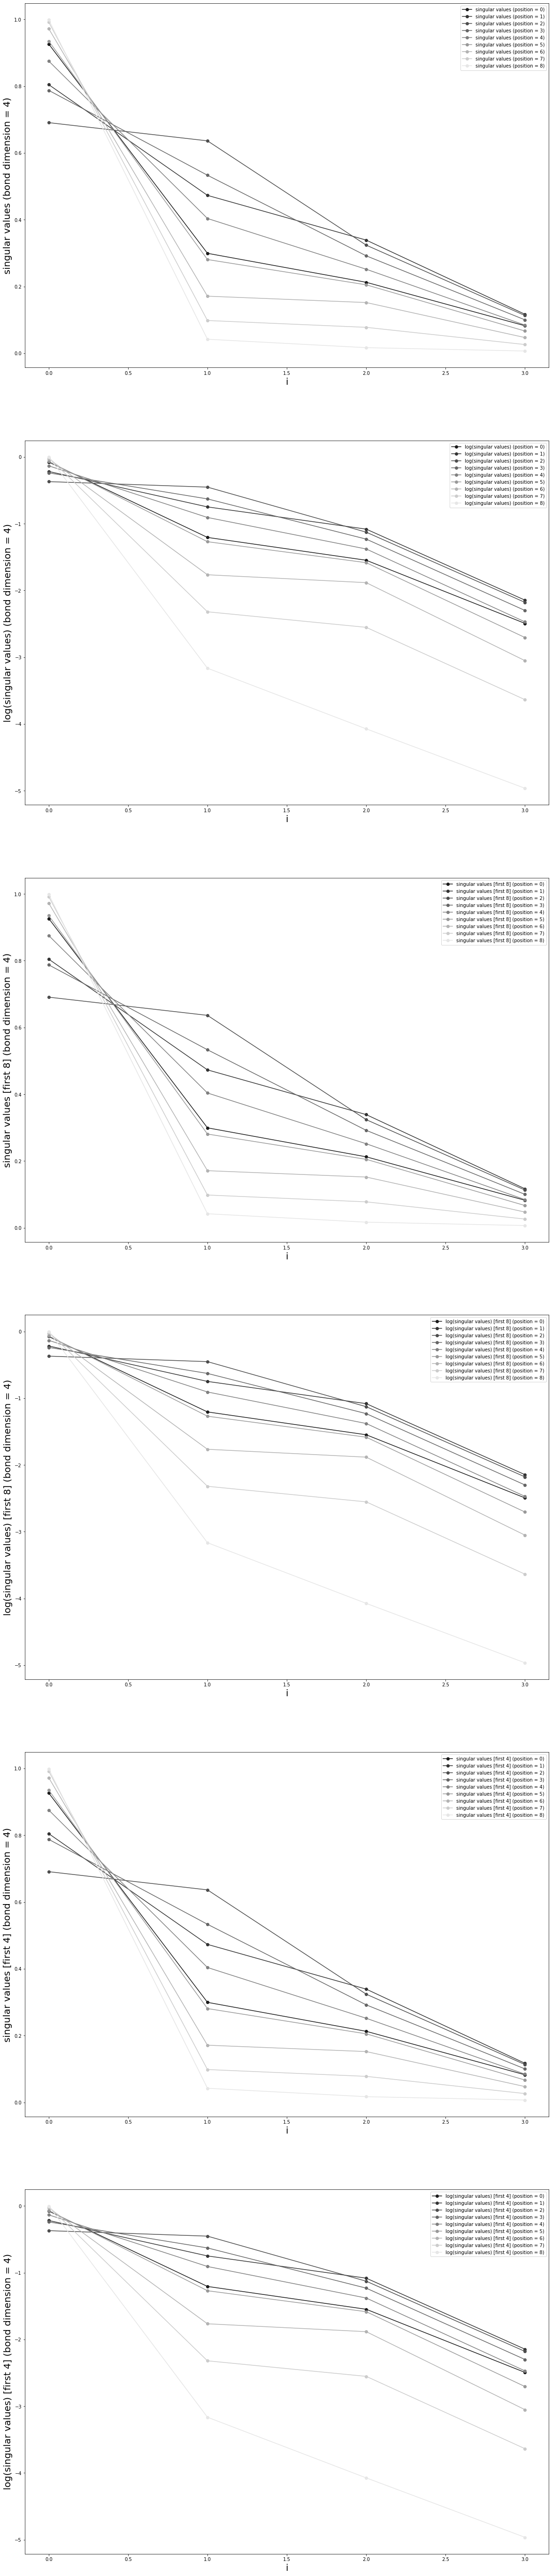

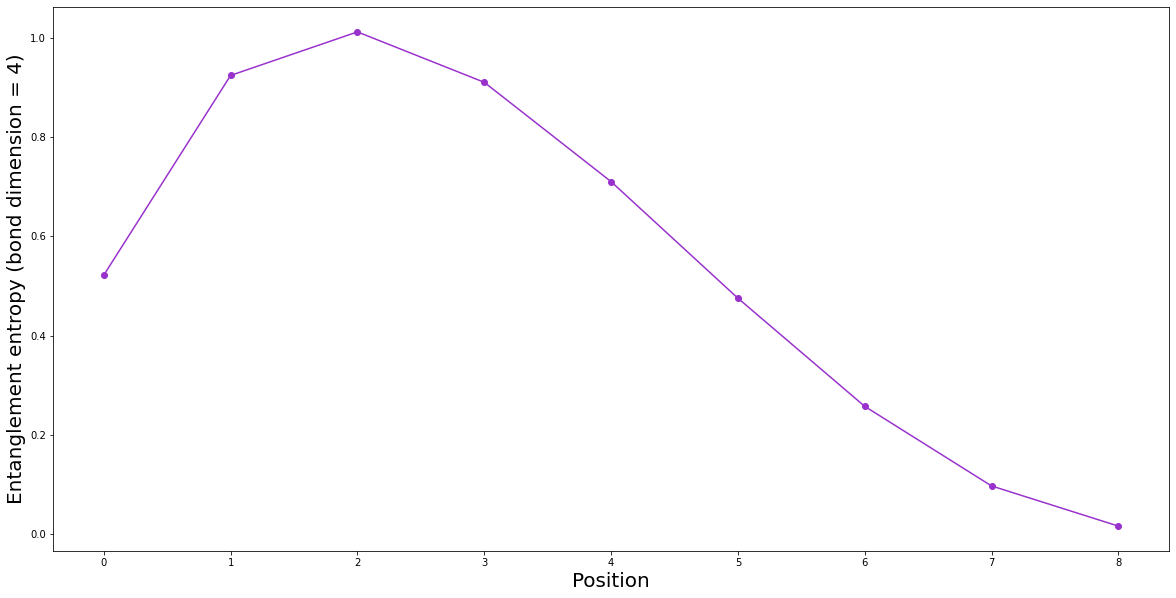

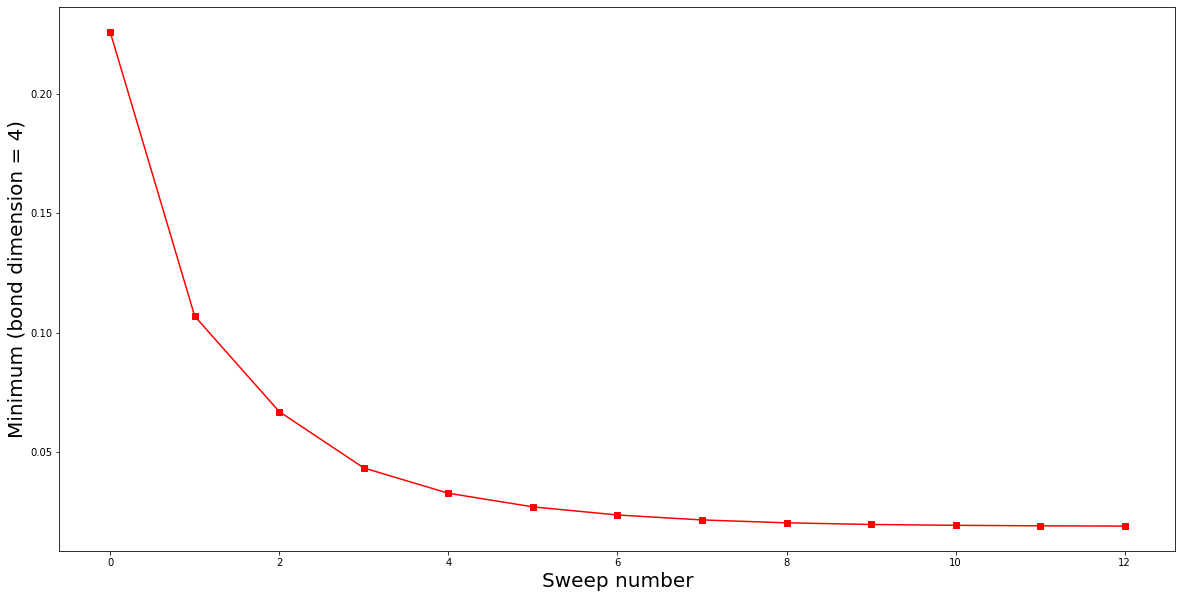

Bond dimension:  8
Sweep: 1 of 1, Energy: 0.015698, Bond dim: 8
CPU times: user 5.13 s, sys: 7.16 s, total: 12.3 s
Wall time: 3.68 s
Minimum:  0.015698100489366817

Sweep: 1 of 1, Energy: 0.015399, Bond dim: 8
CPU times: user 6.14 s, sys: 8.97 s, total: 15.1 s
Wall time: 4.17 s
Minimum:  0.015399370364202358

Sweep: 1 of 1, Energy: 0.015267, Bond dim: 8
CPU times: user 6.11 s, sys: 8.88 s, total: 15 s
Wall time: 4.19 s
Minimum:  0.015266761603180967


Position =  0 :
Entanglement entropy = 0.4795073480441385
Singlular value[0] = 0.935214848588035
Singlular value[1] = 0.2888982164912476
Singlular value[2] = 0.1807096931342111
Singlular value[3] = 0.09620298486000346

Position =  1 :
Entanglement entropy = 0.9359041094117676
Singlular value[0] = 0.8127850081150733
Singlular value[1] = 0.4406424794953458
Singlular value[2] = 0.351262333949577
Singlular value[3] = 0.14662526817168428
Singlular value[4] = 0.011853987061030198
Singlular value[5] = 0.009769936627616018
Singlular value[6] = 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

Position =  7 :
Entanglement entropy = 0.09405517482353913
Singlular value[0] = 0.992143807418449
Singlular value[1] = 0.09763620948196851
Singlular value[2] = 0.07066727318895107
Singlular value[3] = 0.033365143124640534
Singlular value[4] = 0.0023132905461679958
Singlular value[5] = 0.0016720128770729987
Singlular value[6] = 0.0013960828286270794
Singlular value[7] = 0.0008023316337290521

Position =  8 :
Entanglement entropy = 0.014419784253897498
Singlular value[0] = 0.9990744353718379
Singlular value[1] = 0.03973145601277967
Singlular value[2] = 0.014146978222958762
Singlular value[3] = 0.00845854577967743



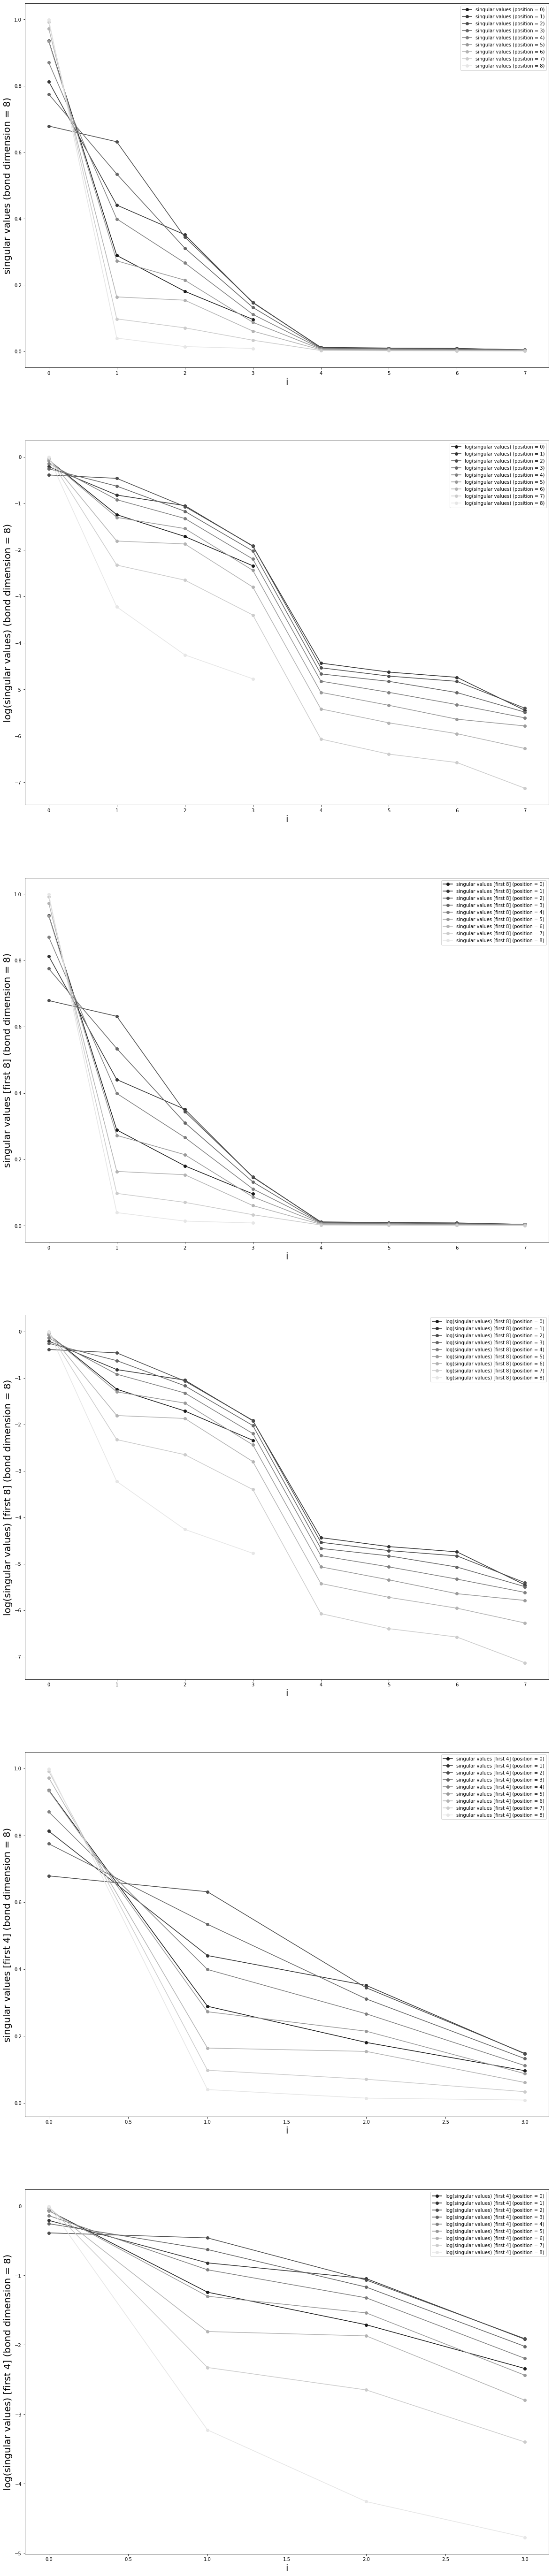

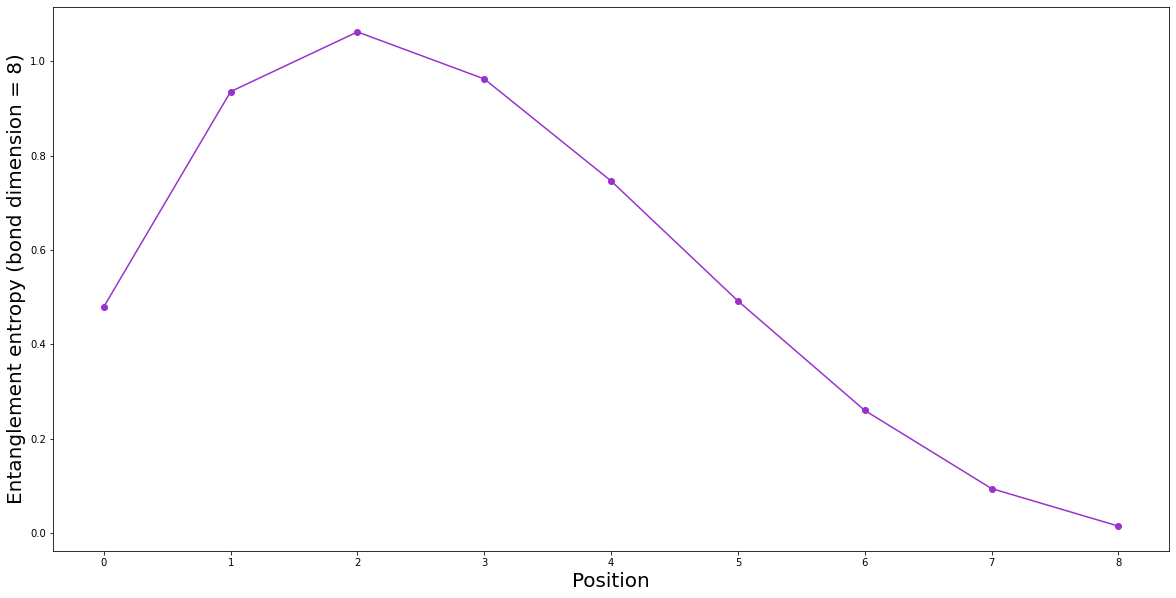

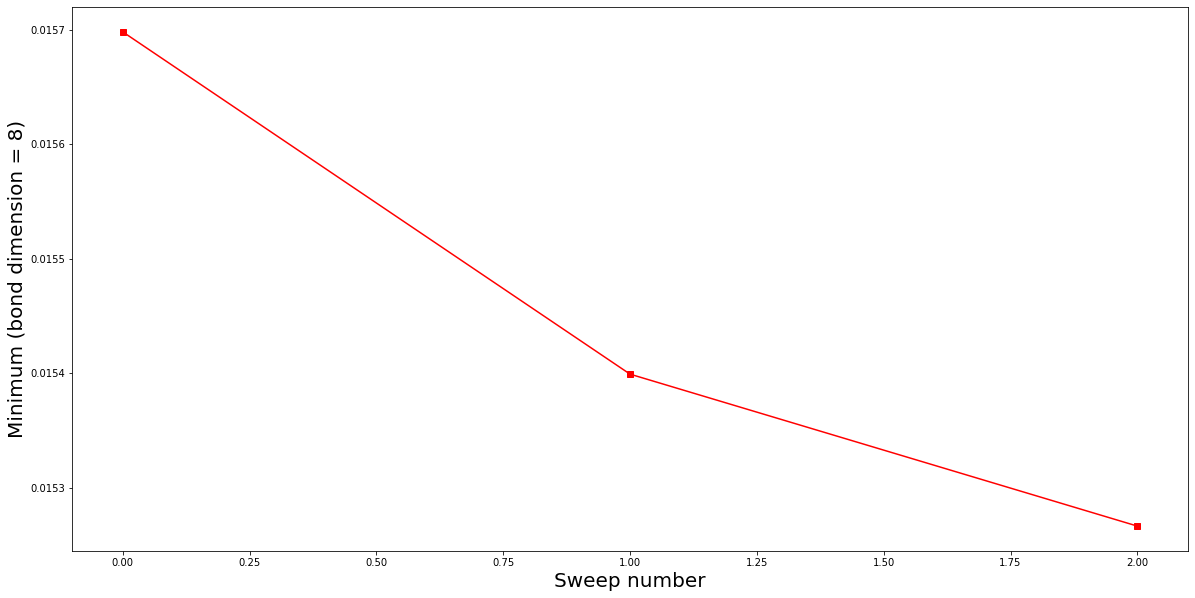

Bond dimension:  16
Sweep: 1 of 1, Energy: 0.012738, Bond dim: 16
CPU times: user 7.6 s, sys: 11.6 s, total: 19.2 s
Wall time: 5.06 s
Minimum:  0.012737501407430685

Sweep: 1 of 1, Energy: 0.012303, Bond dim: 16
CPU times: user 8.73 s, sys: 13.1 s, total: 21.8 s
Wall time: 5.6 s
Minimum:  0.012302509056600242

Sweep: 1 of 1, Energy: 0.012033, Bond dim: 16
CPU times: user 8.6 s, sys: 12.8 s, total: 21.4 s
Wall time: 5.5 s
Minimum:  0.012032581201243175

Sweep: 1 of 1, Energy: 0.011929, Bond dim: 16
CPU times: user 8.93 s, sys: 13.6 s, total: 22.5 s
Wall time: 5.82 s
Minimum:  0.011929335672811625


Position =  0 :
Entanglement entropy = 0.4318890000953087
Singlular value[0] = 0.94409167507179
Singlular value[1] = 0.27629439002143263
Singlular value[2] = 0.1377158896112265
Singlular value[3] = 0.11570070376369648

Position =  1 :
Entanglement entropy = 0.9740358979964928
Singlular value[0] = 0.8183745431694591
Singlular value[1] = 0.3900971851855266
Singlular value[2] = 0.372384021606145

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

Position =  7 :
Entanglement entropy = 0.08631755997151905
Singlular value[0] = 0.9929948359127219
Singlular value[1] = 0.09407562734206129
Singlular value[2] = 0.058708053440927555
Singlular value[3] = 0.03981721242970236
Singlular value[4] = 0.006544516937409468
Singlular value[5] = 0.004465340274426317
Singlular value[6] = 0.00240527235611409
Singlular value[7] = 0.00204684139142045
Singlular value[8] = 0.001771912048263097
Singlular value[9] = 0.0012026423115681958
Singlular value[10] = 0.0008529907207731034
Singlular value[11] = 0.0006984613361226757
Singlular value[12] = 0.00045187783785725005
Singlular value[13] = 0.00035999219515020394
Singlular value[14] = 0.0003133144843647182
Singlular value[15] = 8.927317128948995e-05

Position =  8 :
Entanglement entropy = 0.011950185425147516
Singlular value[0] = 0.9992536333808694
Singlular value[1] = 0.035822955420541557
Singlular value[2] = 0.01048546093781617
Singlular value[3] = 0.009947218153367165



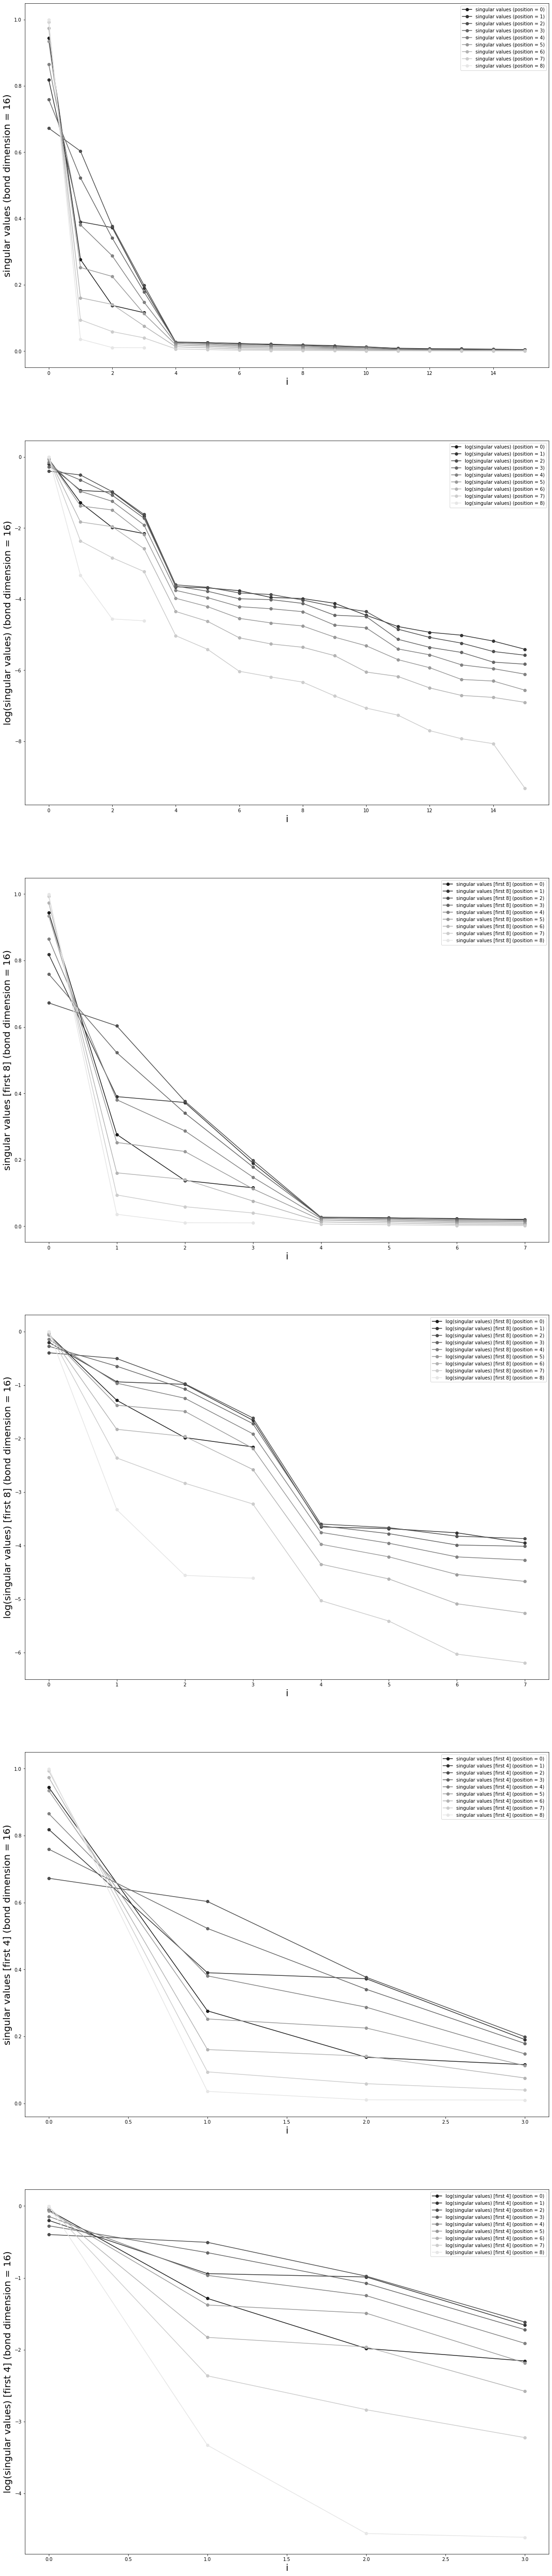

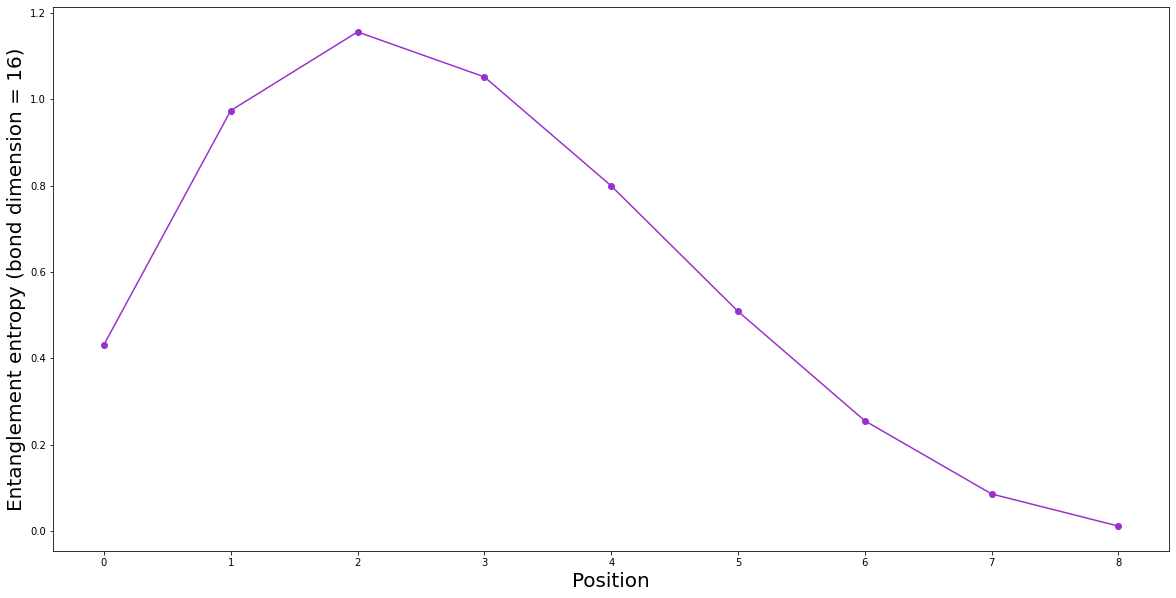

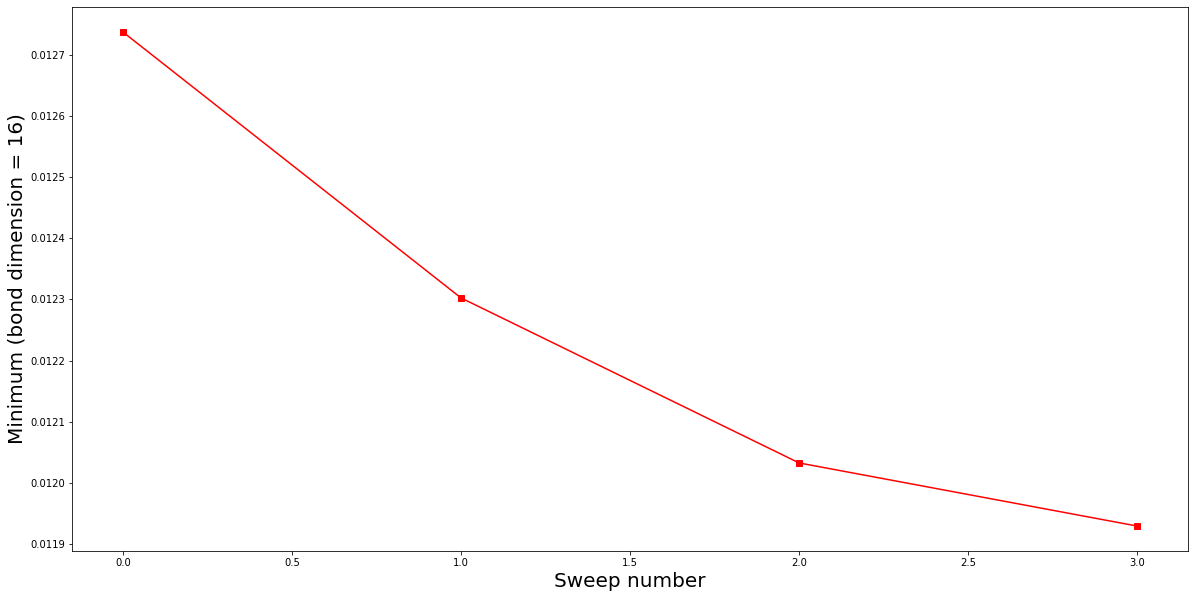

Bond dimension:  32
Sweep: 1 of 1, Energy: 0.010400, Bond dim: 32
CPU times: user 11.8 s, sys: 16 s, total: 27.7 s
Wall time: 7.1 s
Minimum:  0.010399857301245818

Sweep: 1 of 1, Energy: 0.010195, Bond dim: 32
CPU times: user 13.1 s, sys: 16.9 s, total: 30 s
Wall time: 7.64 s
Minimum:  0.010195035523691942

Sweep: 1 of 1, Energy: 0.010109, Bond dim: 32
CPU times: user 13.3 s, sys: 17.7 s, total: 31 s
Wall time: 7.89 s
Minimum:  0.010108919915191139


Position =  0 :
Entanglement entropy = 0.4028765333662016
Singlular value[0] = 0.949041378240562
Singlular value[1] = 0.26605295269783746
Singlular value[2] = 0.12313662192121297
Singlular value[3] = 0.11564454630396205

Position =  1 :
Entanglement entropy = 0.9871824029505492
Singlular value[0] = 0.8230233356253023
Singlular value[1] = 0.383347836839701
Singlular value[2] = 0.3521814916163643
Singlular value[3] = 0.21487339887768786
Singlular value[4] = 0.03246672284417089
Singlular value[5] = 0.02955439439406789
Singlular value[6] = 0.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

Singlular value[22] = 0.0007058092703663063
Singlular value[23] = 0.0006532227028963005
Singlular value[24] = 0.0006455173193021896
Singlular value[25] = 0.0005310614380066676
Singlular value[26] = 0.00039593919612458624
Singlular value[27] = 0.0003696186349116958
Singlular value[28] = 0.00031727247028100224
Singlular value[29] = 0.00027063163867066623
Singlular value[30] = 0.00024554964468879363
Singlular value[31] = 0.0001752679605523906

Position =  7 :
Entanglement entropy = 0.08203060324977021
Singlular value[0] = 0.9934544075227157
Singlular value[1] = 0.0918497970801353
Singlular value[2] = 0.050717766942063675
Singlular value[3] = 0.04328005166176118
Singlular value[4] = 0.009592485161775794
Singlular value[5] = 0.005658262651739079
Singlular value[6] = 0.004216358162753147
Singlular value[7] = 0.003465440488281876
Singlular value[8] = 0.0022675389489295616
Singlular value[9] = 0.0018024612977513021
Singlular value[10] = 0.0011748215149506973
Singlular value[11] = 0.00116146070

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

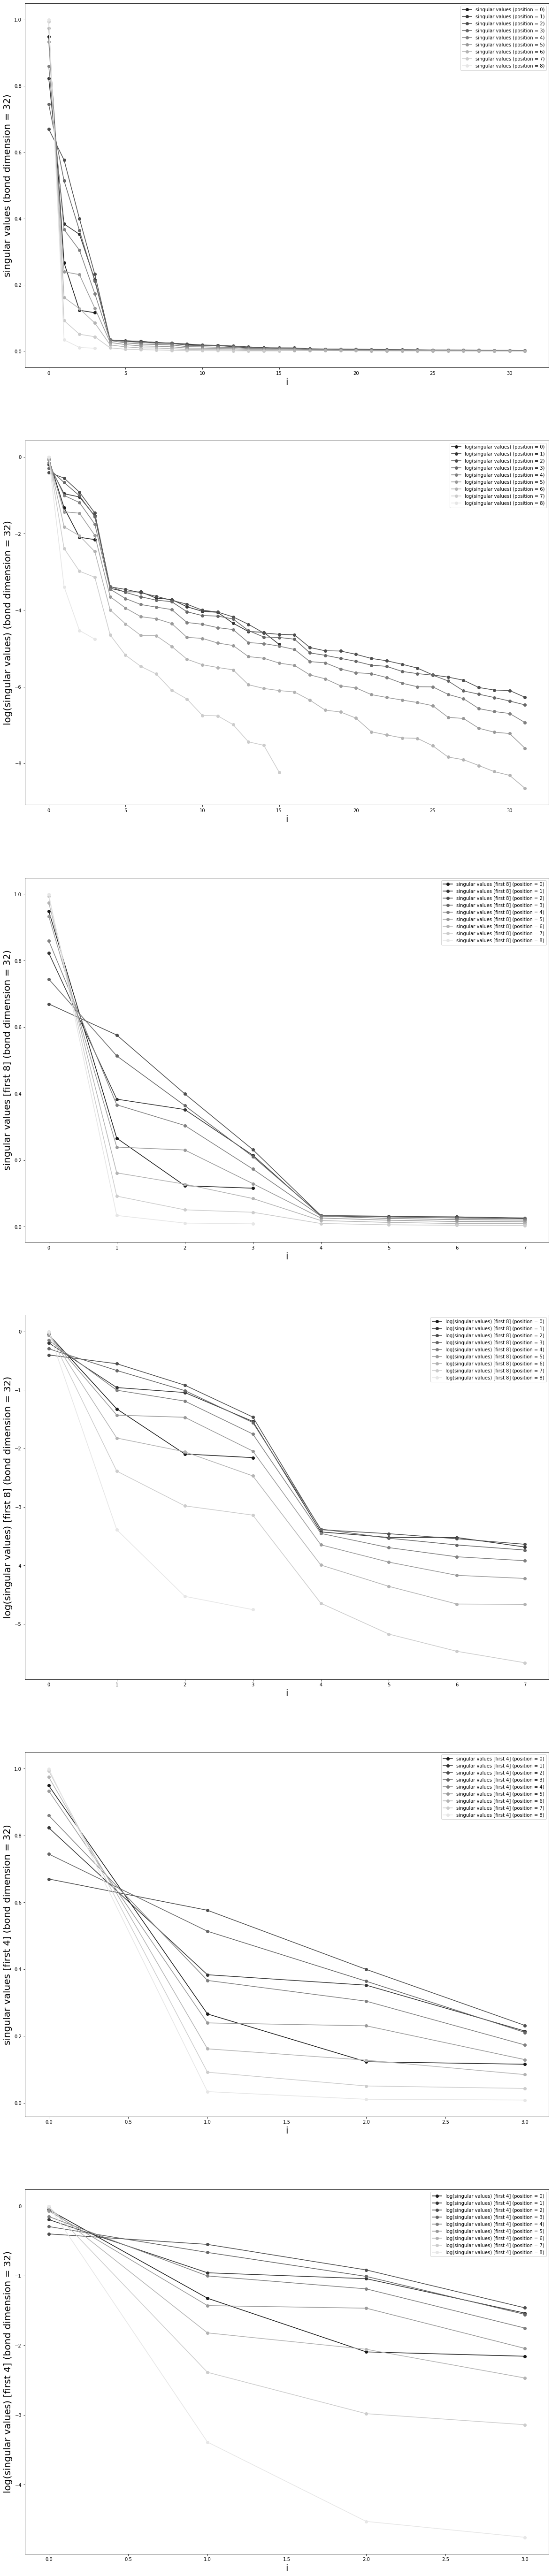

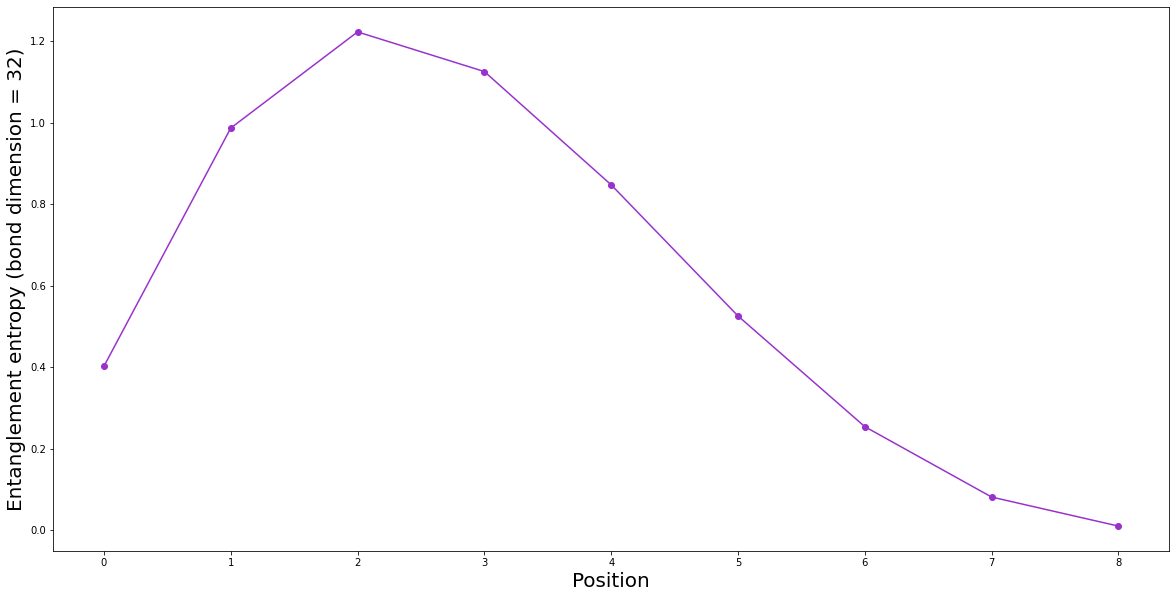

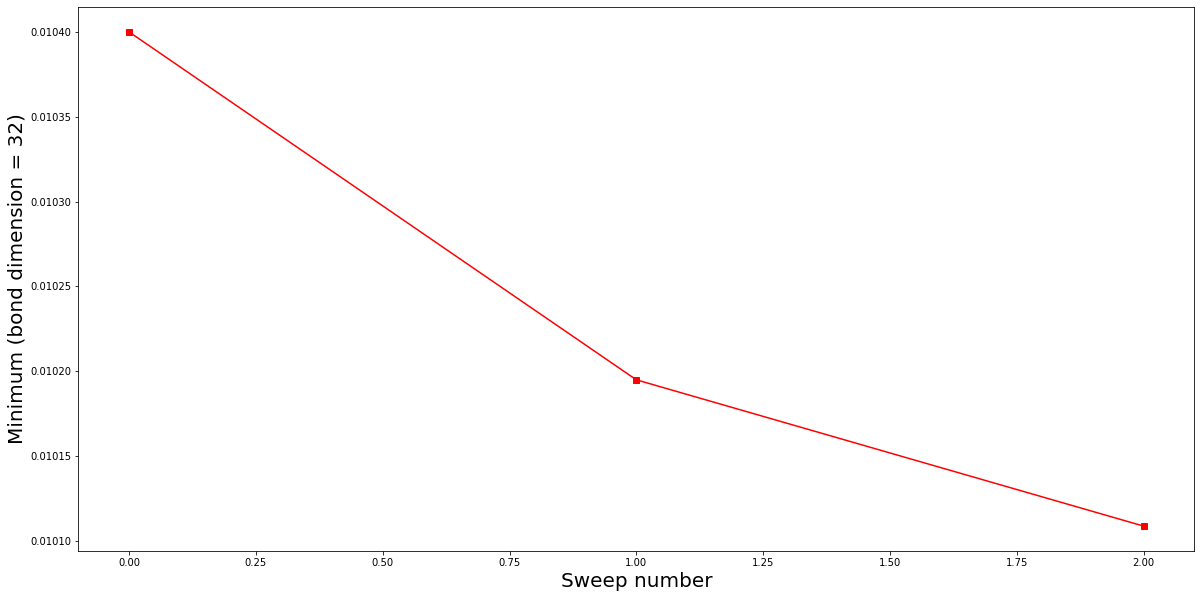

Bond dimension:  64
Sweep: 1 of 1, Energy: 0.009371, Bond dim: 64
CPU times: user 26.4 s, sys: 27.9 s, total: 54.3 s
Wall time: 13.8 s
Minimum:  0.009370519296396429

Sweep: 1 of 1, Energy: 0.009268, Bond dim: 64
CPU times: user 33.3 s, sys: 33.5 s, total: 1min 6s
Wall time: 16.9 s
Minimum:  0.009268328955639005

Sweep: 1 of 1, Energy: 0.009221, Bond dim: 64
CPU times: user 33.2 s, sys: 33.6 s, total: 1min 6s
Wall time: 16.9 s
Minimum:  0.009220845705691927


Position =  0 :
Entanglement entropy = 0.3819849410140519
Singlular value[0] = 0.9526771638624772
Singlular value[1] = 0.256053788715195
Singlular value[2] = 0.12512082190030704
Singlular value[3] = 0.10577078361500611

Position =  1 :
Entanglement entropy = 0.9927398649462884
Singlular value[0] = 0.8270282129604235
Singlular value[1] = 0.39001281700987234
Singlular value[2] = 0.3199449928098273
Singlular value[3] = 0.23155988677957945
Singlular value[4] = 0.03848629110644557
Singlular value[5] = 0.034703949468881015
Singlular val

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

Position =  6 :
Entanglement entropy = 0.25320253947389537
Singlular value[0] = 0.9749799771730198
Singlular value[1] = 0.16213509164199696
Singlular value[2] = 0.11658755107795063
Singlular value[3] = 0.0903683015592755
Singlular value[4] = 0.022923457605110845
Singlular value[5] = 0.015867161632004093
Singlular value[6] = 0.012813234676138388
Singlular value[7] = 0.01255633333994021
Singlular value[8] = 0.008122257722020887
Singlular value[9] = 0.006663377932143122
Singlular value[10] = 0.006003845586574843
Singlular value[11] = 0.005327937114641408
Singlular value[12] = 0.0053234305131143345
Singlular value[13] = 0.0036695328380065106
Singlular value[14] = 0.0031161300214604475
Singlular value[15] = 0.0029345658219260954
Singlular value[16] = 0.002756083509679613
Singlular value[17] = 0.0026115932471823776
Singlular value[18] = 0.0021133108830048313
Singlular value[19] = 0.002069255991634579
Singlular value[20] = 0.0014860472889700765
Singlular value[21] = 0.0010936312945738717
Sing

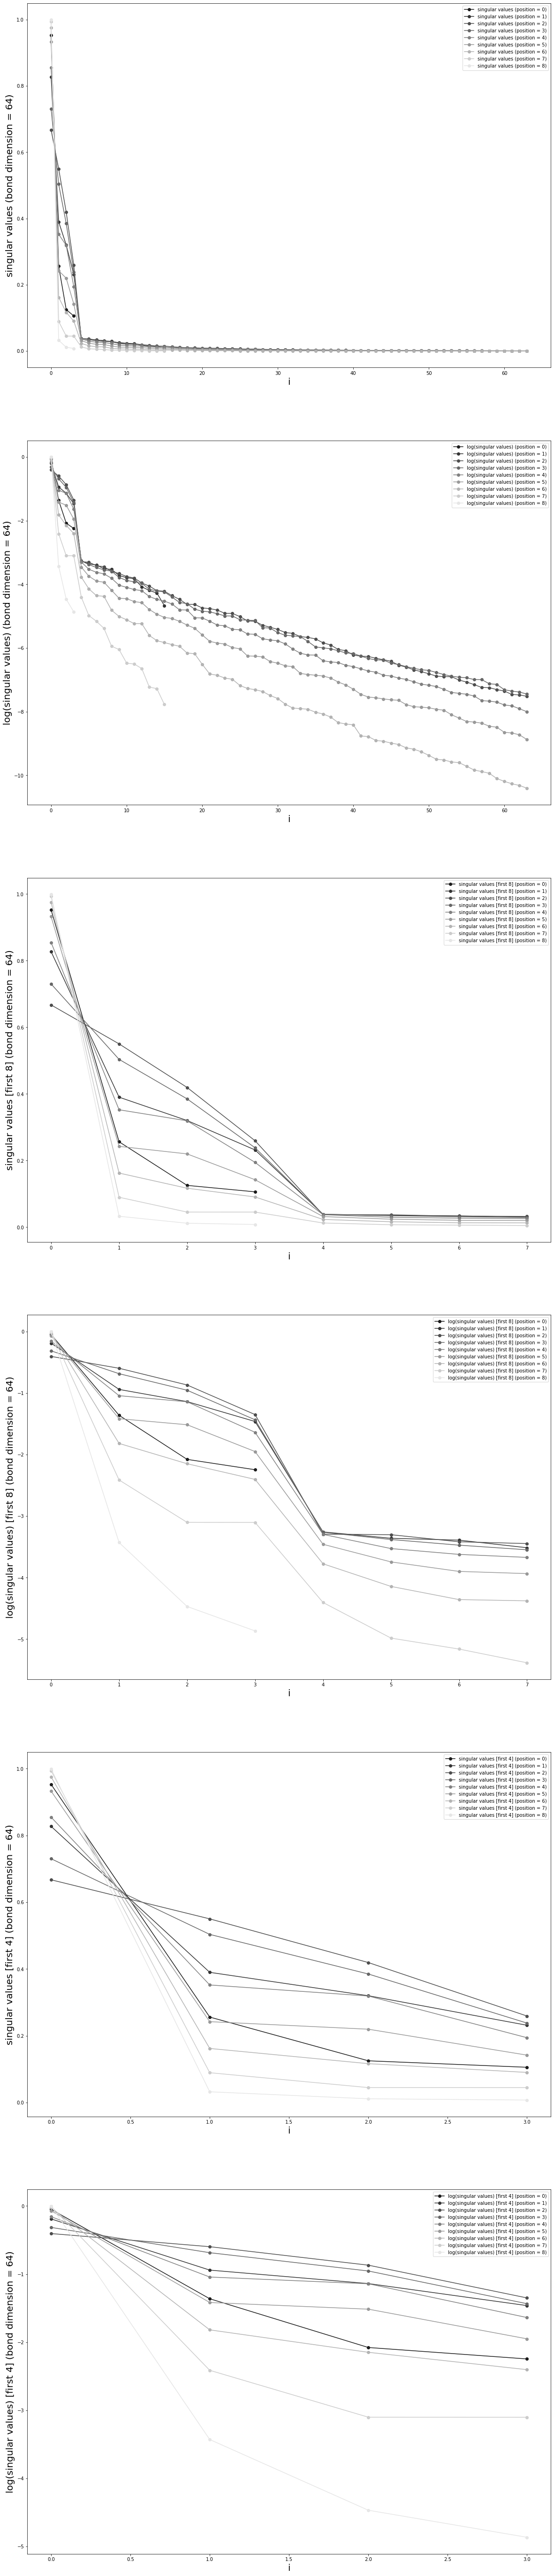

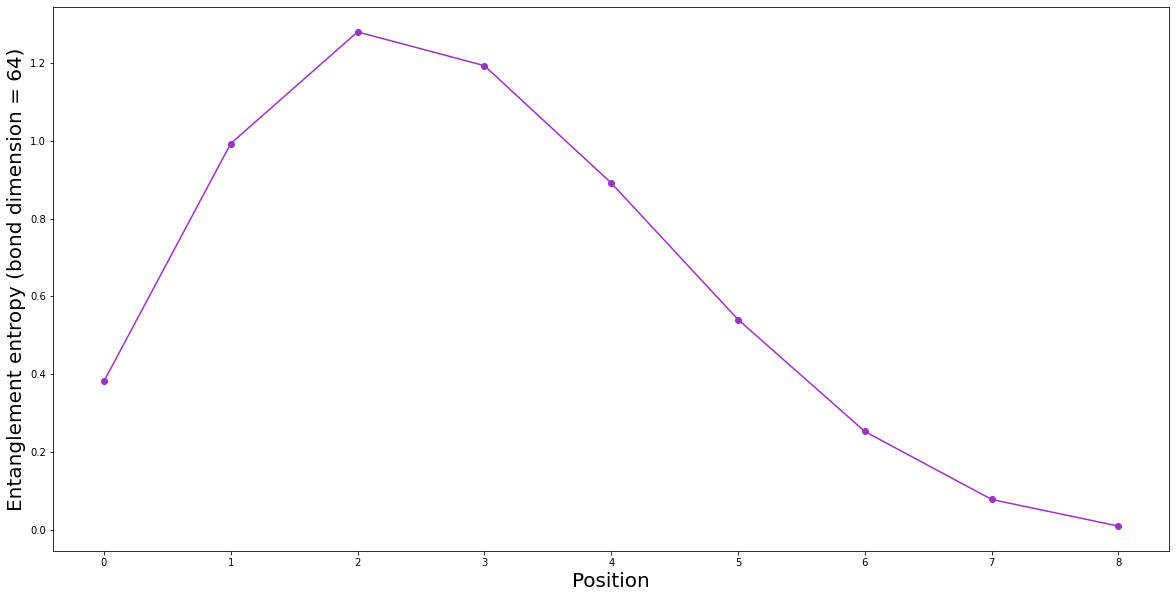

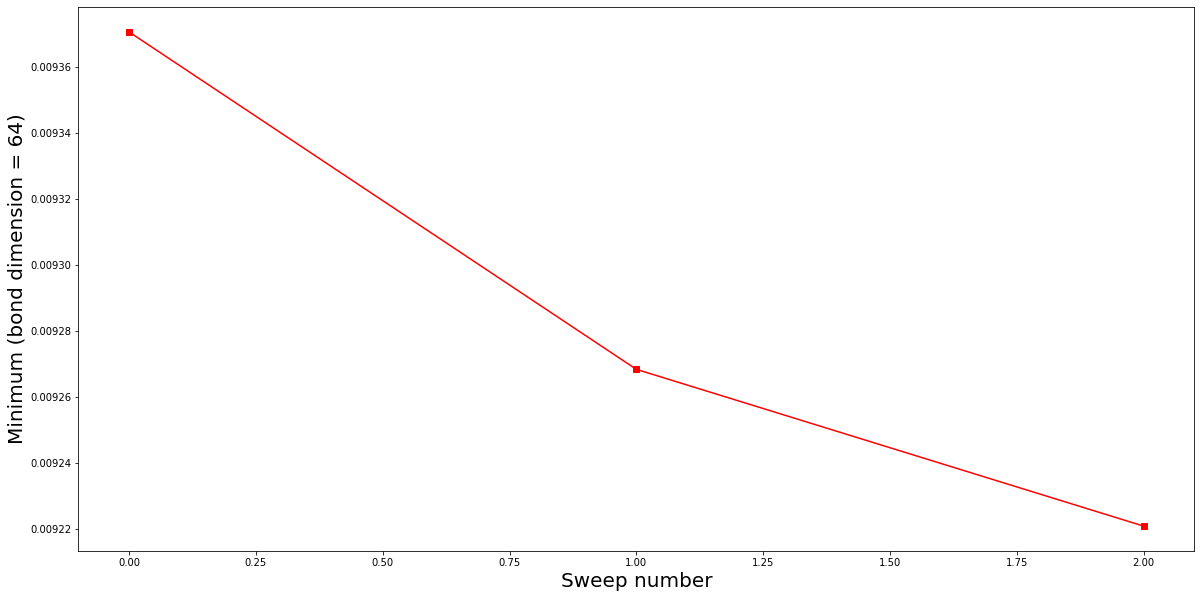

Bond dimension:  128
Sweep: 1 of 1, Energy: 0.009057, Bond dim: 128
CPU times: user 1min 12s, sys: 1min 7s, total: 2min 20s
Wall time: 39.9 s
Minimum:  0.009057130453573592

Sweep: 1 of 1, Energy: 0.009030, Bond dim: 128
CPU times: user 1min 32s, sys: 1min 16s, total: 2min 49s
Wall time: 43.9 s
Minimum:  0.009030165889168273


Position =  0 :
Entanglement entropy = 0.3727111136296757
Singlular value[0] = 0.9542956770919377
Singlular value[1] = 0.25126677888735927
Singlular value[2] = 0.12438041060630524
Singlular value[3] = 0.1035098061471375

Position =  1 :
Entanglement entropy = 0.9889327354701974
Singlular value[0] = 0.8296286235337789
Singlular value[1] = 0.3910327100444432
Singlular value[2] = 0.30705353222560927
Singlular value[3] = 0.23634647289221444
Singlular value[4] = 0.0400512700317375
Singlular value[5] = 0.03589543449190759
Singlular value[6] = 0.035020095886025115
Singlular value[7] = 0.031391099929566145
Singlular value[8] = 0.030196574378590198
Singlular value[9] = 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

0.0015742421398851738
Singlular value[56] = 0.0015650937002747718
Singlular value[57] = 0.0015351826483480289
Singlular value[58] = 0.0014331045678251575
Singlular value[59] = 0.001383630129740312
Singlular value[60] = 0.0013716529515385583
Singlular value[61] = 0.001303331501710213
Singlular value[62] = 0.0012787772981836668
Singlular value[63] = 0.0012093571209761665
Singlular value[64] = 0.0012087092662967714
Singlular value[65] = 0.0011096902931052204
Singlular value[66] = 0.001089283917210775
Singlular value[67] = 0.0010666178895880271
Singlular value[68] = 0.0010629414606634505
Singlular value[69] = 0.0010026358472187311
Singlular value[70] = 0.0009720662864121537
Singlular value[71] = 0.0009295743739079754
Singlular value[72] = 0.0009227529971084669
Singlular value[73] = 0.0008645421370633348
Singlular value[74] = 0.000836684209288173
Singlular value[75] = 0.0008059961070654184
Singlular value[76] = 0.0007778208593923196
Singlular value[77] = 0.0007625417972605691
Singlular valu

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

Position =  5 :
Entanglement entropy = 0.5480772036342904
Singlular value[0] = 0.9317265066550281
Singlular value[1] = 0.2454294933992331
Singlular value[2] = 0.21452116859031445
Singlular value[3] = 0.14728269769842953
Singlular value[4] = 0.03274677191630324
Singlular value[5] = 0.024900176767980554
Singlular value[6] = 0.02187236271110336
Singlular value[7] = 0.021127072123116982
Singlular value[8] = 0.01589709765442727
Singlular value[9] = 0.013036341358345594
Singlular value[10] = 0.012648359831220828
Singlular value[11] = 0.01146663089984363
Singlular value[12] = 0.011274758205984526
Singlular value[13] = 0.009228268559967931
Singlular value[14] = 0.008015527048837285
Singlular value[15] = 0.007232049126506766
Singlular value[16] = 0.006899529122663801
Singlular value[17] = 0.00666044121377218
Singlular value[18] = 0.00569950864457216
Singlular value[19] = 0.005539240383326976
Singlular value[20] = 0.004329685349572029
Singlular value[21] = 0.003551013199888679
Singlular value[22

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

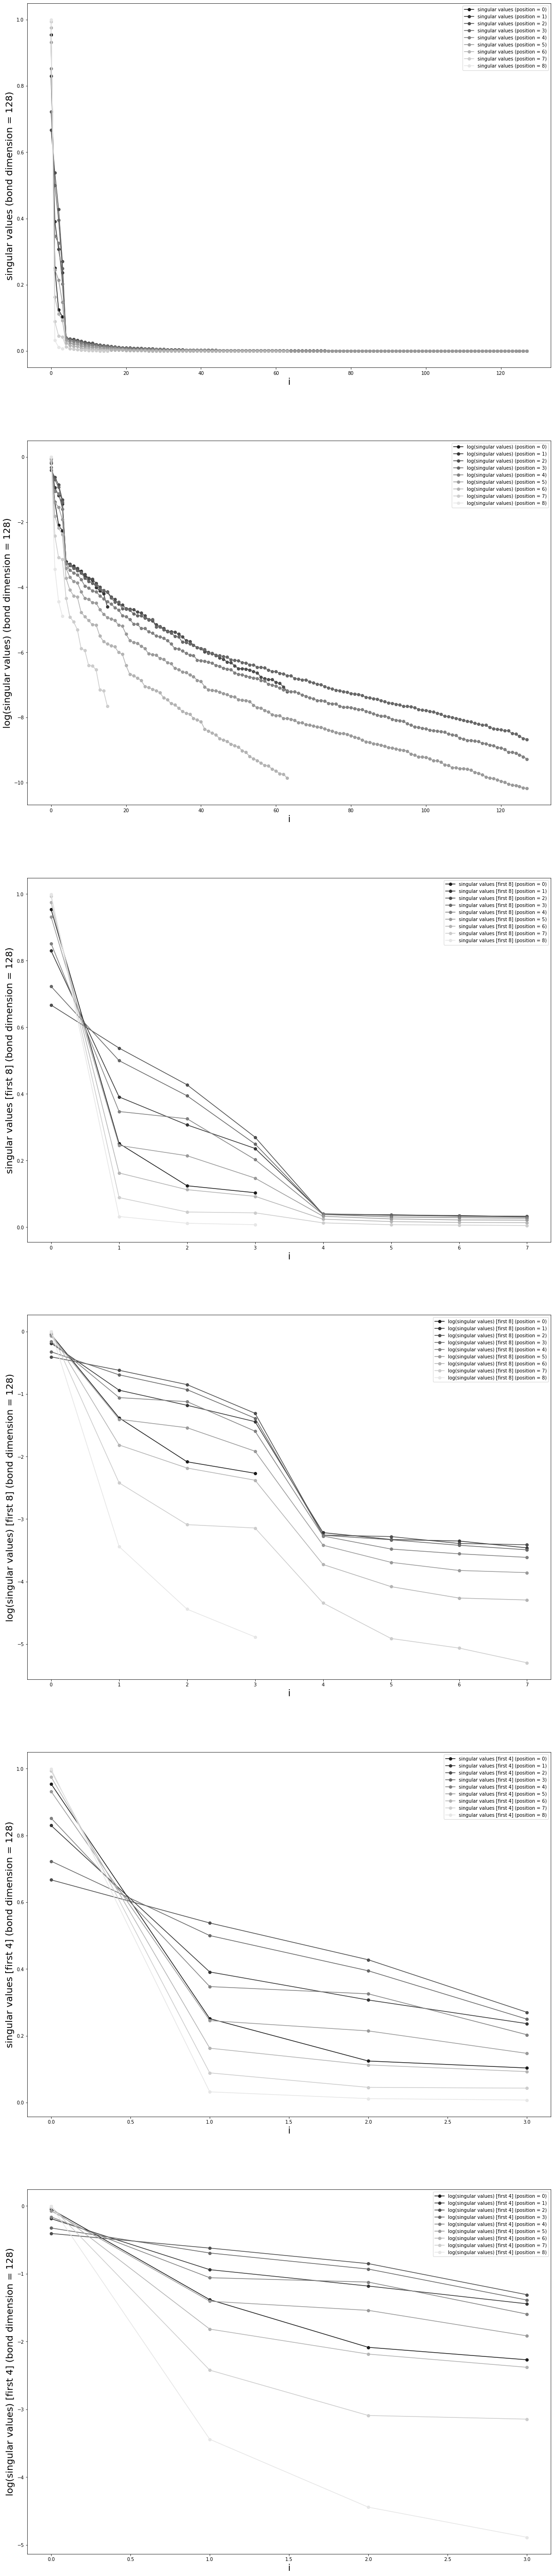

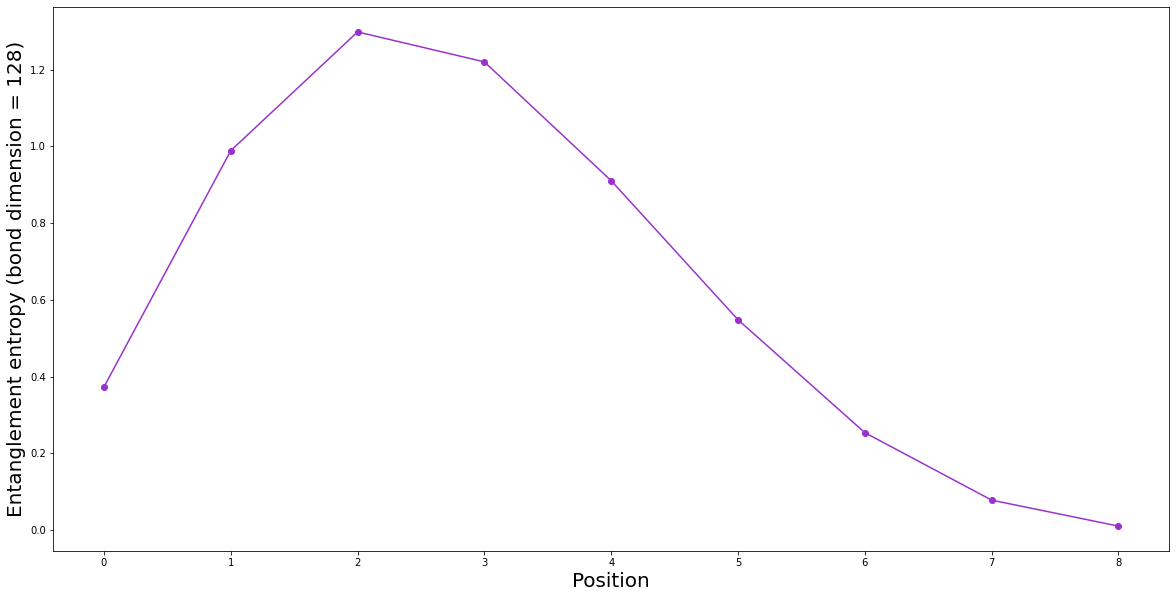

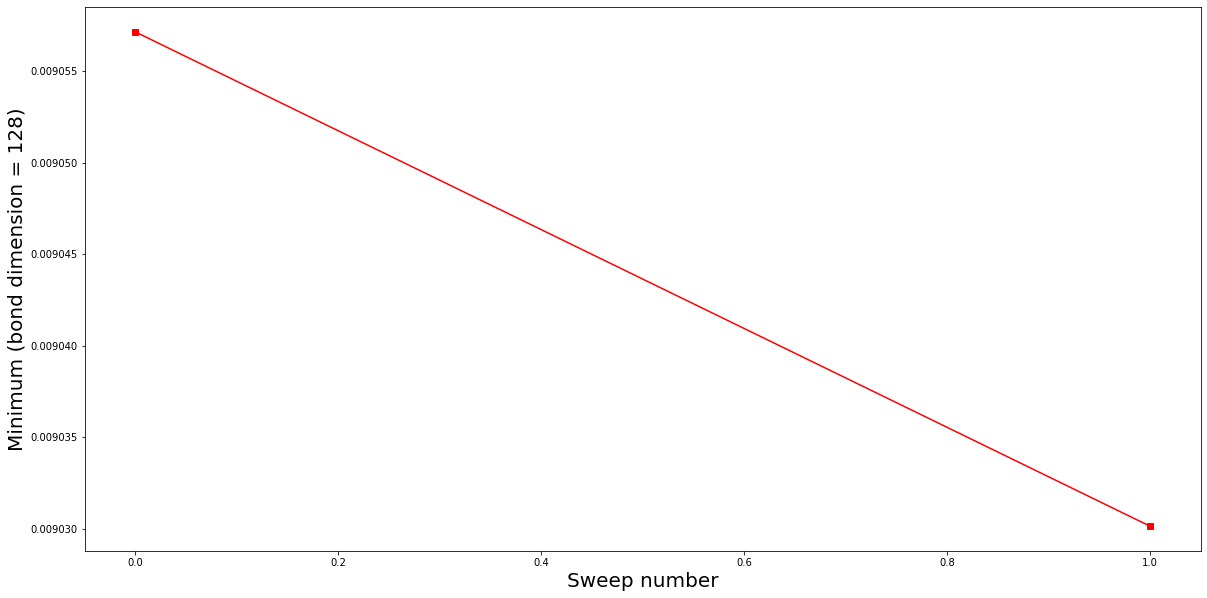

Bond dimension:  256
Sweep: 1 of 1, Energy: 0.008994, Bond dim: 256
CPU times: user 4min 29s, sys: 3min 1s, total: 7min 30s
Wall time: 1min 53s
Minimum:  0.008993675762505537

Sweep: 1 of 1, Energy: 0.008983, Bond dim: 256
CPU times: user 5min 50s, sys: 3min 47s, total: 9min 37s
Wall time: 2min 25s
Minimum:  0.008982867458304566


Position =  0 :
Entanglement entropy = 0.36624061894459464
Singlular value[0] = 0.9554060000819673
Singlular value[1] = 0.2479996880699479
Singlular value[2] = 0.12344692986510494
Singlular value[3] = 0.10225646791995192

Position =  1 :
Entanglement entropy = 0.9838479295866942
Singlular value[0] = 0.8317441741940502
Singlular value[1] = 0.3910011322982285
Singlular value[2] = 0.2990021436587234
Singlular value[3] = 0.23862262236867957
Singlular value[4] = 0.04072680766051693
Singlular value[5] = 0.03633486691167314
Singlular value[6] = 0.035645387851412906
Singlular value[7] = 0.03203493034613038
Singlular value[8] = 0.030517779546827318
Singlular value[9] 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

0.004321283995306713
Singlular value[34] = 0.0042846020927880014
Singlular value[35] = 0.0037206287897807657
Singlular value[36] = 0.0036516866817020302
Singlular value[37] = 0.0035050830644017894
Singlular value[38] = 0.0034061059927725074
Singlular value[39] = 0.0031122729396358116
Singlular value[40] = 0.0030678869800168703
Singlular value[41] = 0.003052551897204512
Singlular value[42] = 0.0027170095803325457
Singlular value[43] = 0.002640060978877132
Singlular value[44] = 0.0025738694826811276
Singlular value[45] = 0.002547891867206538
Singlular value[46] = 0.002510524749717787
Singlular value[47] = 0.0024032607867762066
Singlular value[48] = 0.0022269152831116625
Singlular value[49] = 0.0021785914722155728
Singlular value[50] = 0.002171545040155556
Singlular value[51] = 0.0021360938265621134
Singlular value[52] = 0.0021100532537454138
Singlular value[53] = 0.002029197326167788
Singlular value[54] = 0.0018887092398045576
Singlular value[55] = 0.001846856261611964
Singlular value[56

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

8.468512192258827e-06
Singlular value[231] = 8.27972457743712e-06
Singlular value[232] = 7.95054856859309e-06
Singlular value[233] = 7.859927056883586e-06
Singlular value[234] = 7.77673129188928e-06
Singlular value[235] = 7.440424416980117e-06
Singlular value[236] = 7.240392171074846e-06
Singlular value[237] = 7.158210329699106e-06
Singlular value[238] = 6.878661833543059e-06
Singlular value[239] = 6.818626297533921e-06
Singlular value[240] = 6.703299577588853e-06
Singlular value[241] = 6.387692763453319e-06
Singlular value[242] = 6.324824388479297e-06
Singlular value[243] = 6.13462294122156e-06
Singlular value[244] = 6.050301620039805e-06
Singlular value[245] = 5.8149168889290675e-06
Singlular value[246] = 5.780779993285975e-06
Singlular value[247] = 5.357807923628675e-06
Singlular value[248] = 5.290062222030597e-06
Singlular value[249] = 5.19859926896343e-06
Singlular value[250] = 4.995159876279083e-06
Singlular value[251] = 4.927992378579585e-06
Singlular value[252] = 4.085875393487

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

Position =  7 :
Entanglement entropy = 0.07700298846907917
Singlular value[0] = 0.9939861291439877
Singlular value[1] = 0.08834747765191697
Singlular value[2] = 0.04568024758416986
Singlular value[3] = 0.04210196546610411
Singlular value[4] = 0.013216925430859387
Singlular value[5] = 0.007589643938774402
Singlular value[6] = 0.006528731894188608
Singlular value[7] = 0.005149722385227884
Singlular value[8] = 0.0029006168397553074
Singlular value[9] = 0.002731111337028128
Singlular value[10] = 0.001719412747865452
Singlular value[11] = 0.0017007969049099353
Singlular value[12] = 0.0015148543696868783
Singlular value[13] = 0.0008324306764364437
Singlular value[14] = 0.0007987371321041623
Singlular value[15] = 0.0005065664697980686

Position =  8 :
Entanglement entropy = 0.009975500350250749
Singlular value[0] = 0.9993960051612747
Singlular value[1] = 0.03179262917594058
Singlular value[2] = 0.01186979646573378
Singlular value[3] = 0.0074807439221348335



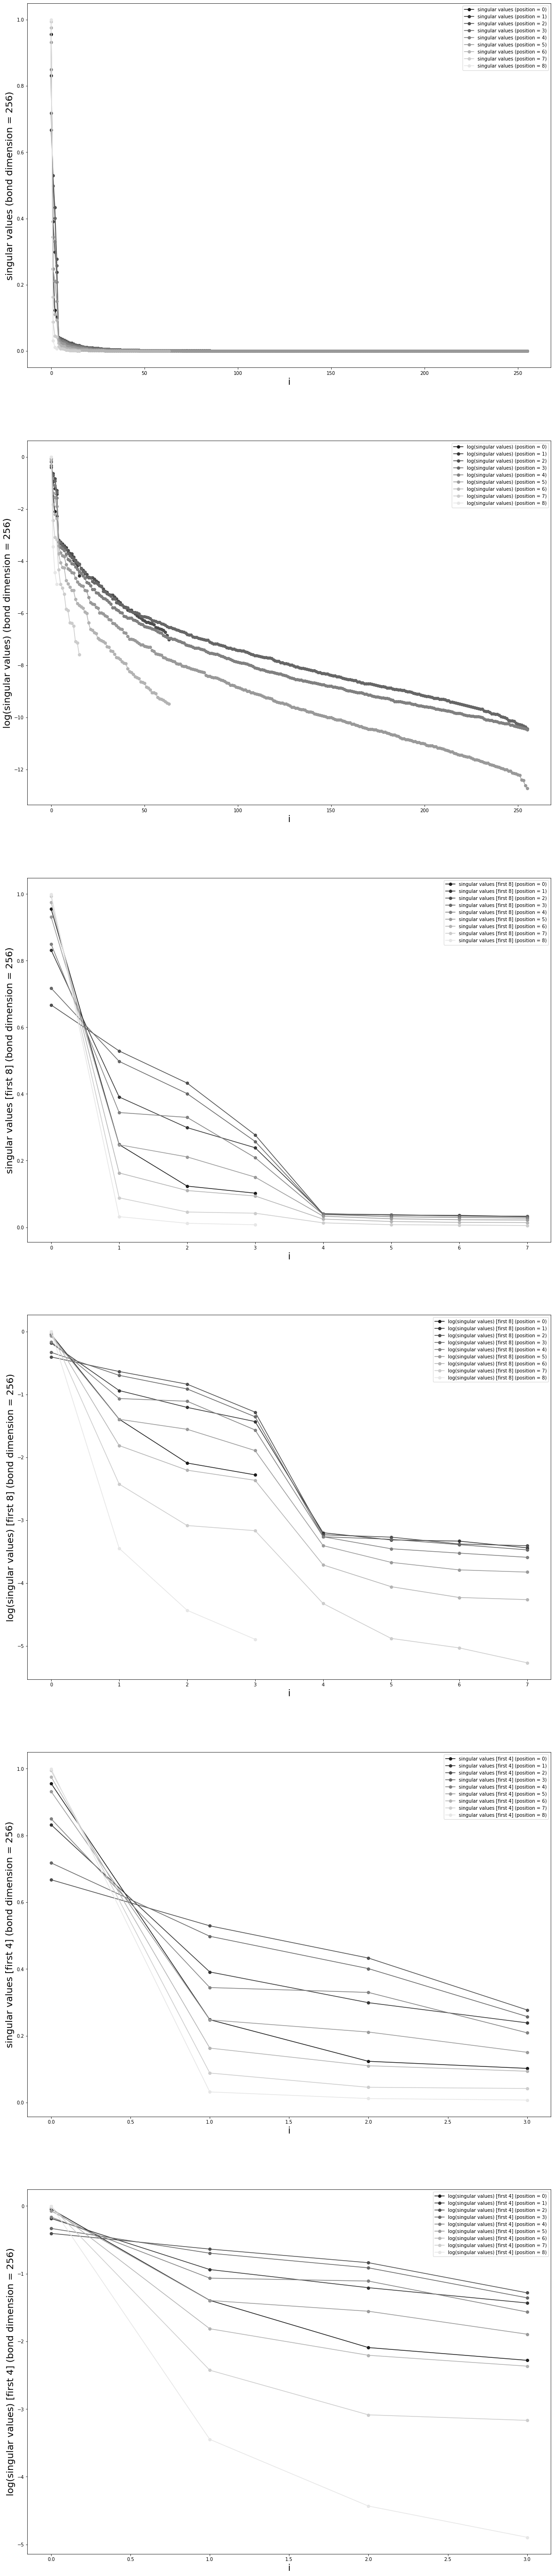

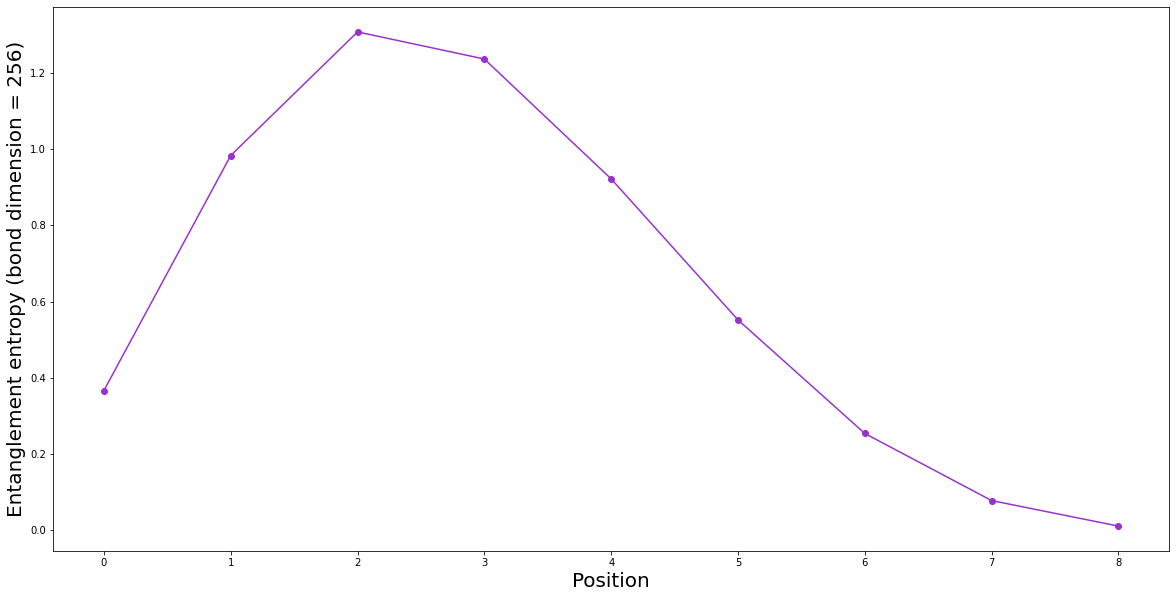

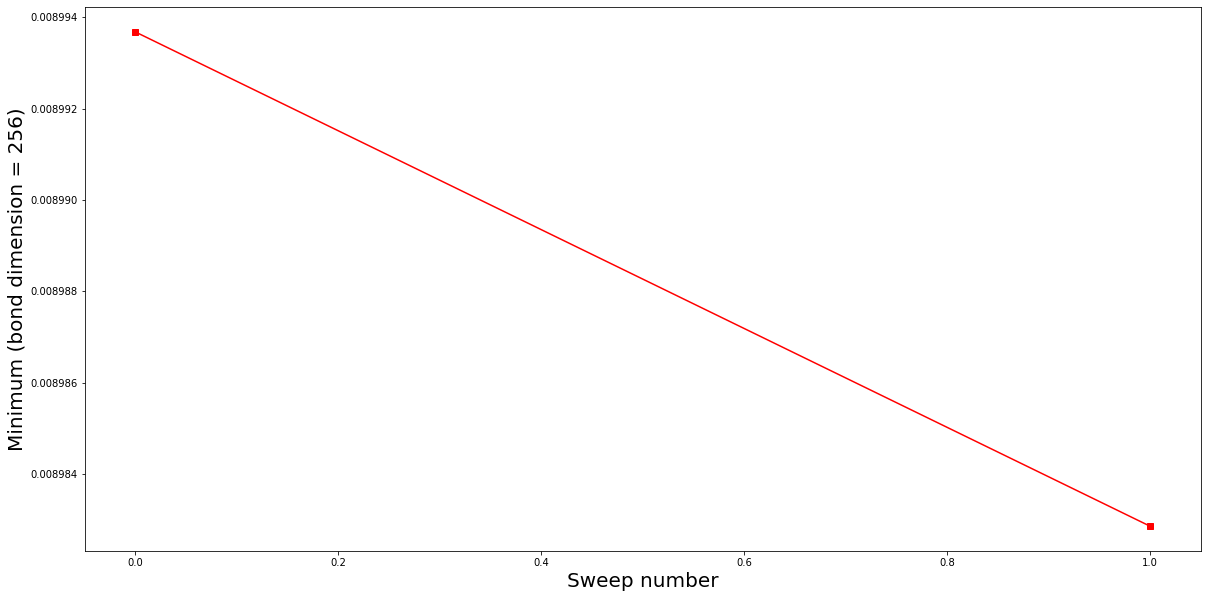

###################################################

Position =  5 :
Entanglement entropy = 0.7100736541897714
Singlular value[0] = 0.8753695341481659
Singlular value[1] = 0.4038885505660283
Singlular value[2] = 0.2518975222900759
Singlular value[3] = 0.08455681918696291

Position =  5 :
Entanglement entropy = 0.7464534114772875
Singlular value[0] = 0.8702842411737607
Singlular value[1] = 0.39892548352817775
Singlular value[2] = 0.2663533950467962
Singlular value[3] = 0.11125770087576922
Singlular value[4] = 0.00803605848110246
Singlular value[5] = 0.006319019583052671
Singlular value[6] = 0.004855205642839543
Singlular value[7] = 0.0036482643911170324

Position =  5 :
Entanglement entropy = 0.7997427257662842
Singlular value[0] = 0.8654577831831979
Singlular value[1] = 0.38069484301817647
Singlular value[2] = 0.2872553727331976
Singlular value[3] = 0.14780283934721186
Singlular value[4] = 0.02341744772801527
Singlular value[5] = 0.019120265892625755
Singlular value[6] = 0.014806648571

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

0.0005473052979157258
Singlular value[57] = 0.0004739073113680578
Singlular value[58] = 0.0004662672887919611
Singlular value[59] = 0.0004523944553180182
Singlular value[60] = 0.0004131082499209049
Singlular value[61] = 0.0004019454694441899
Singlular value[62] = 0.0003669482285910321
Singlular value[63] = 0.0003338206976044142

Position =  5 :
Entanglement entropy = 0.9105913294752355
Singlular value[0] = 0.8516487871829345
Singlular value[1] = 0.34721416277226924
Singlular value[2] = 0.325515630722362
Singlular value[3] = 0.2029870868413294
Singlular value[4] = 0.03793199318861055
Singlular value[5] = 0.03080484282689291
Singlular value[6] = 0.028550806416970196
Singlular value[7] = 0.026955221673466374
Singlular value[8] = 0.02331410455274051
Singlular value[9] = 0.019008103192949505
Singlular value[10] = 0.018019111451097265
Singlular value[11] = 0.016469510020339088
Singlular value[12] = 0.015939751845329066
Singlular value[13] = 0.014075076332065551
Singlular value[14] = 0.012821

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

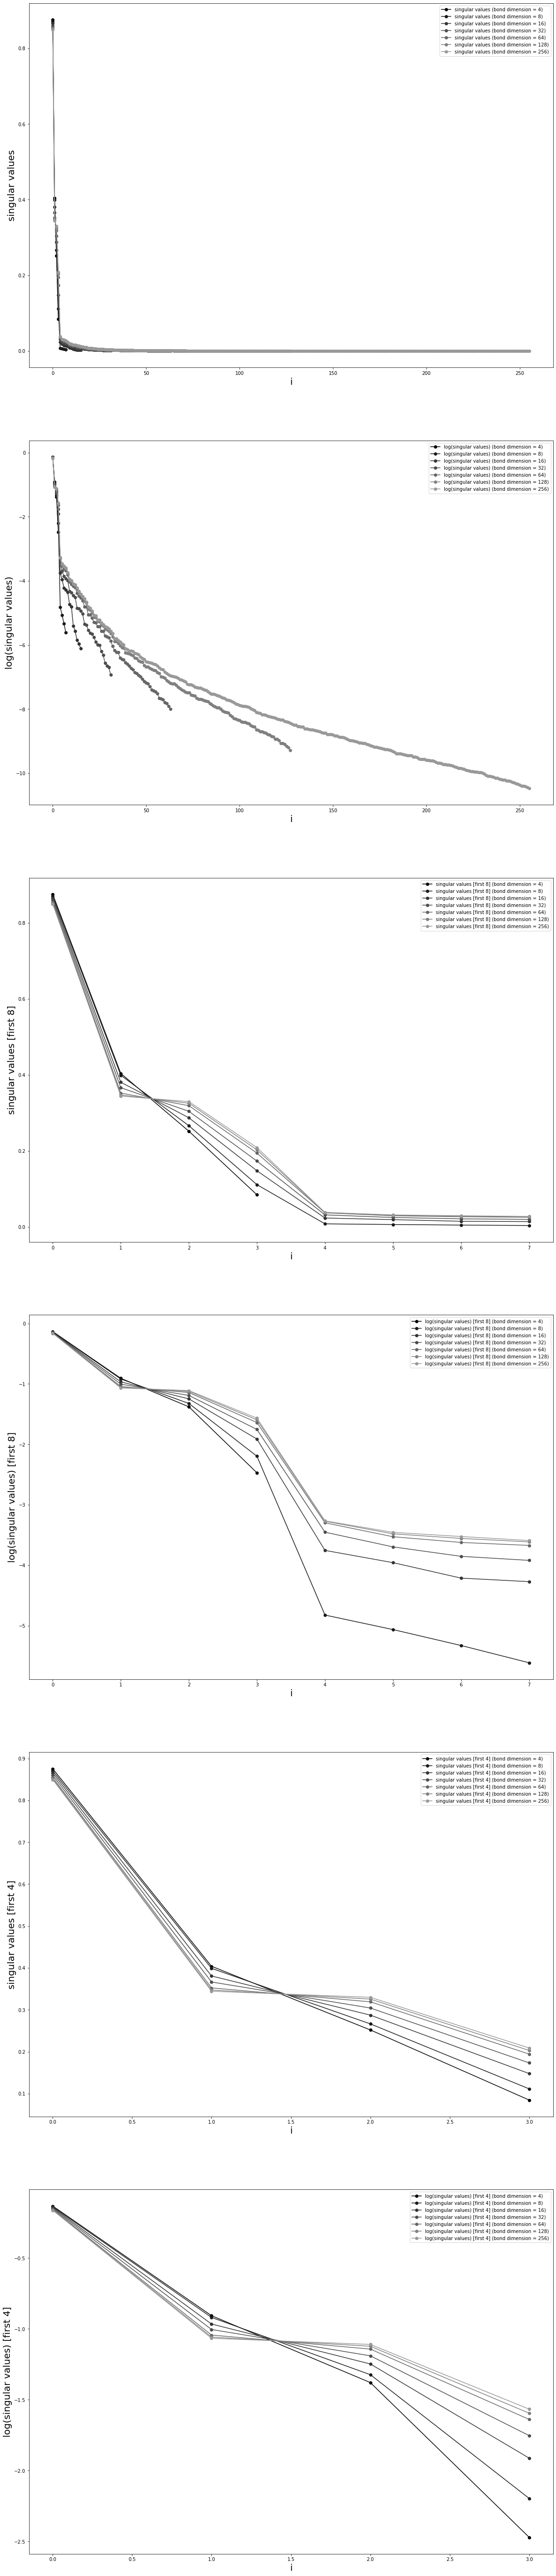

###################################################

First singular value:
chi = 4: 0.8753695341481659
chi = 8: 0.8702842411737607
chi = 16: 0.8654577831831979
chi = 32: 0.8599068450327306
chi = 64: 0.8545766188291337
chi = 128: 0.8516487871829345
chi = 256: 0.8495662681959002

Second singular value:
chi = 4: 0.4038885505660283
chi = 8: 0.39892548352817775
chi = 16: 0.38069484301817647
chi = 32: 0.3663513316900673
chi = 64: 0.35223459134550056
chi = 128: 0.34721416277226924
chi = 256: 0.34428989142226163

Third singular value:
chi = 4: 0.2518975222900759
chi = 8: 0.2663533950467962
chi = 16: 0.2872553727331976
chi = 32: 0.30425993137940294
chi = 64: 0.3190660321480336
chi = 128: 0.325515630722362
chi = 256: 0.32972877587125005

Forth singular value:
chi = 4: 0.08455681918696291
chi = 8: 0.11125770087576922
chi = 16: 0.14780283934721186
chi = 32: 0.17328038334382934
chi = 64: 0.19426525725832122
chi = 128: 0.2029870868413294
chi = 256: 0.20883266931448918



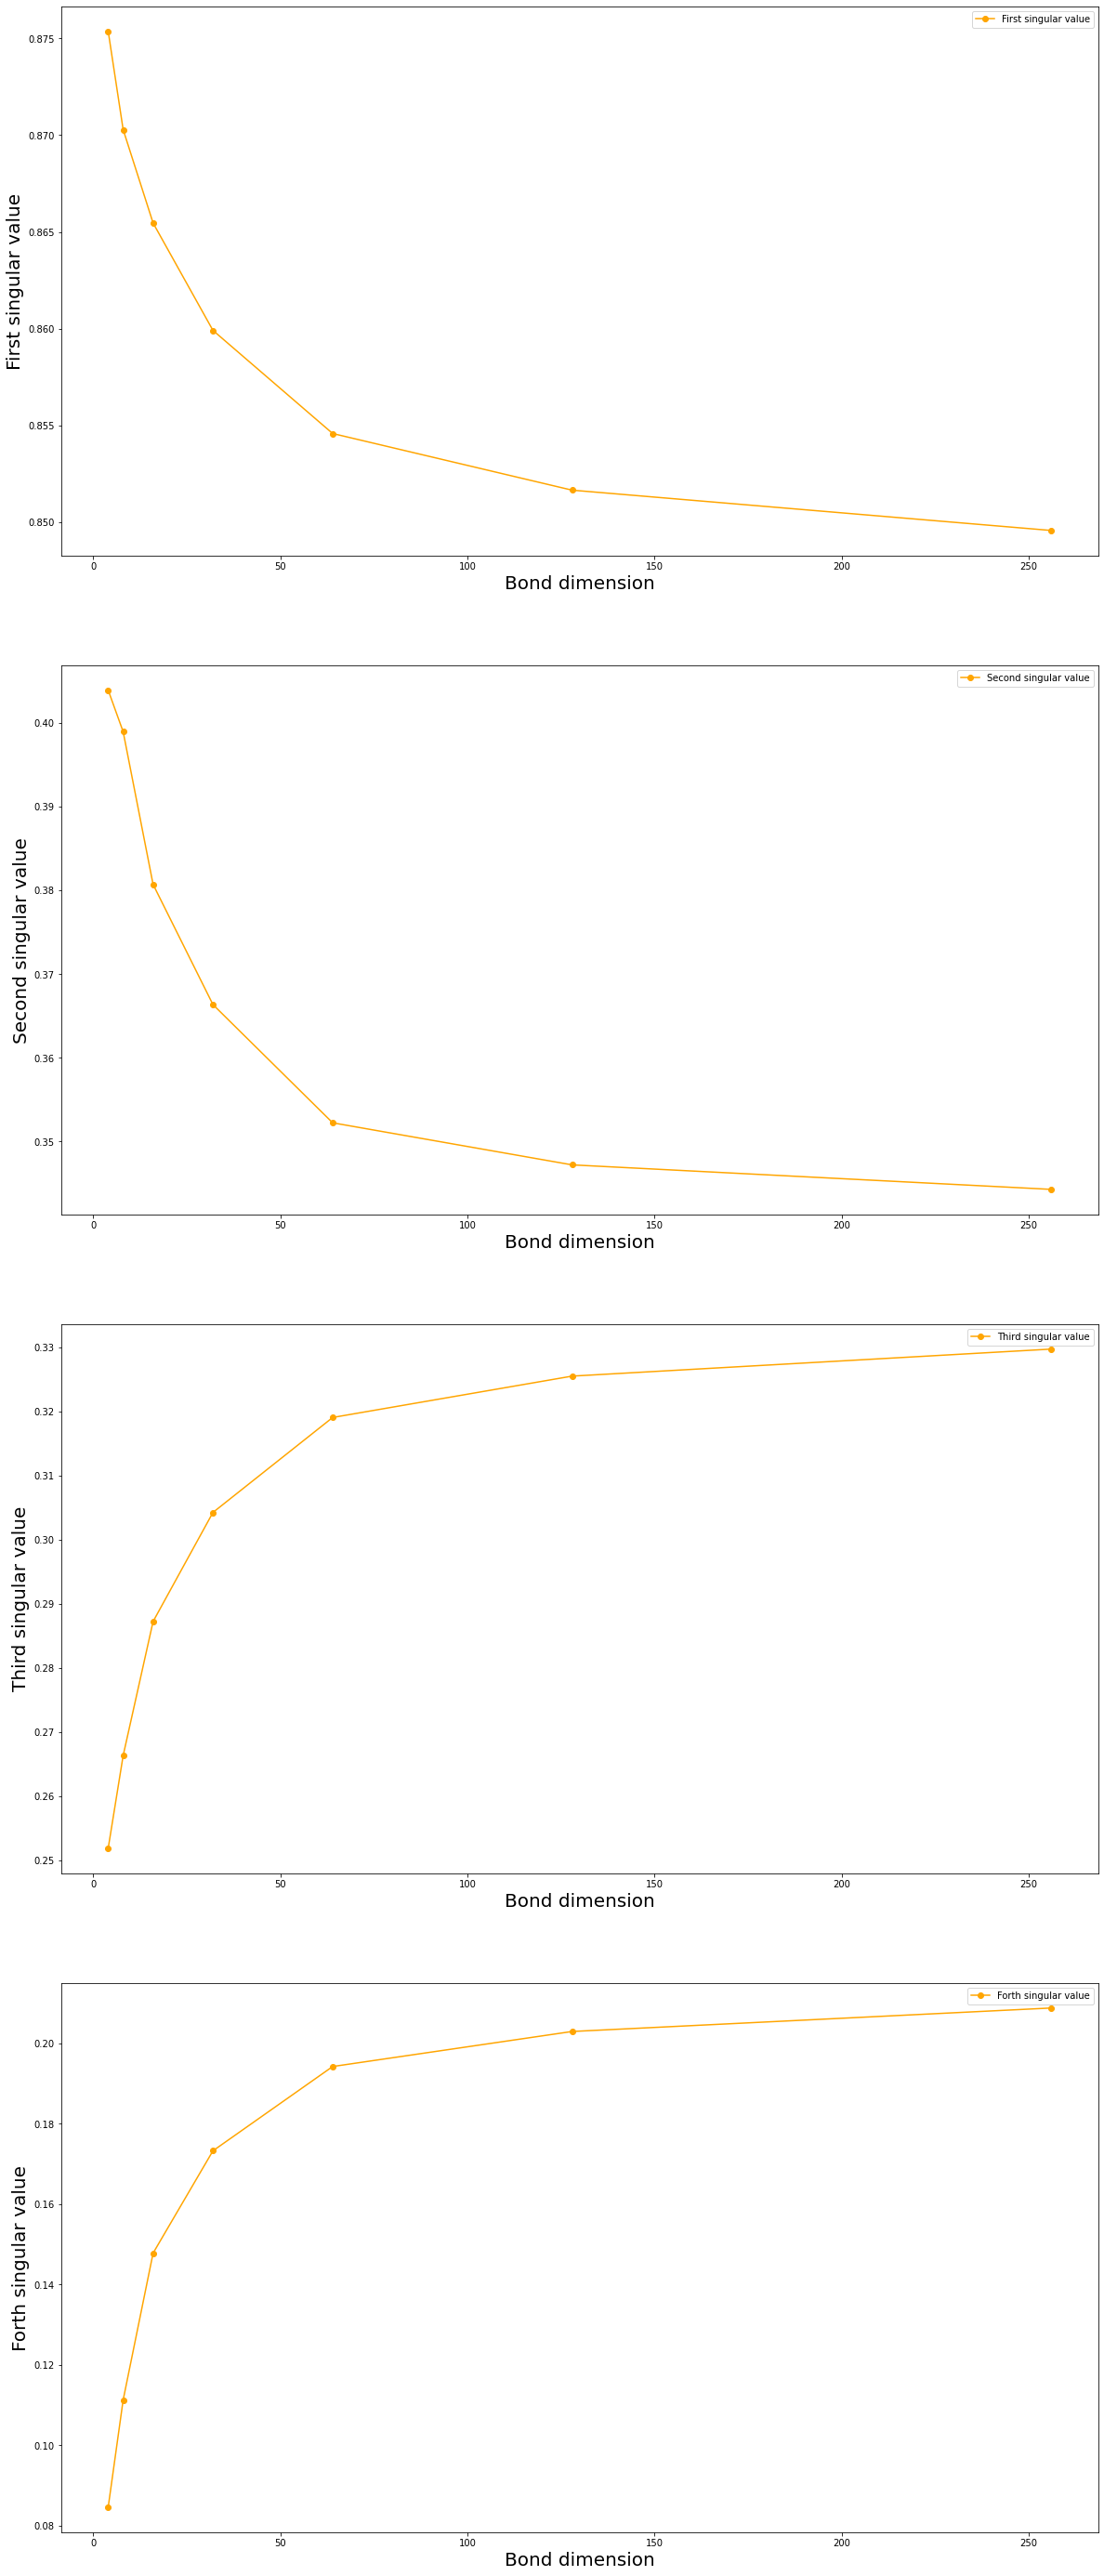

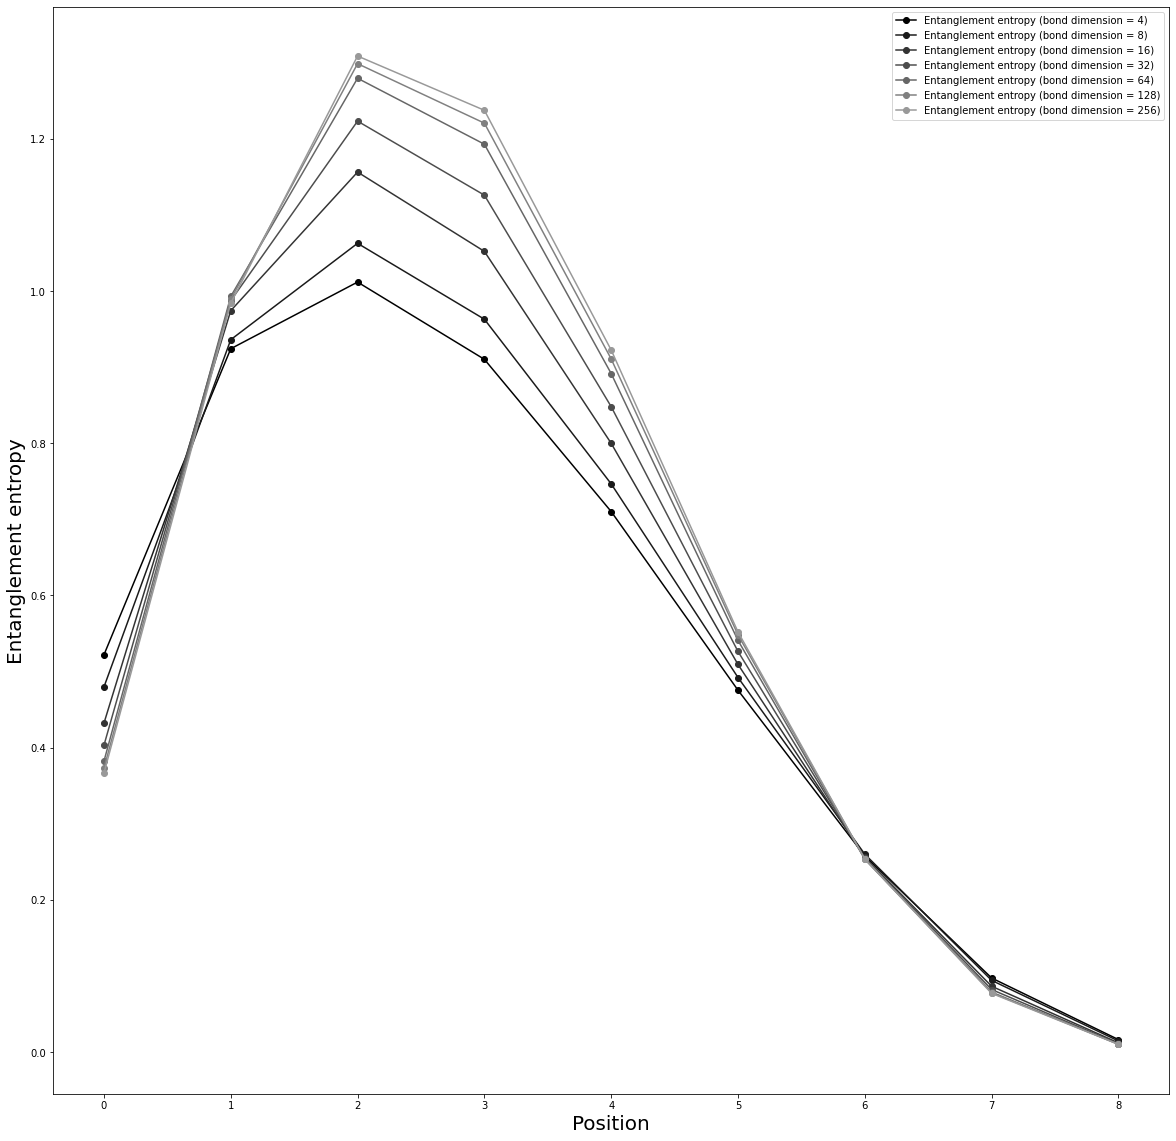

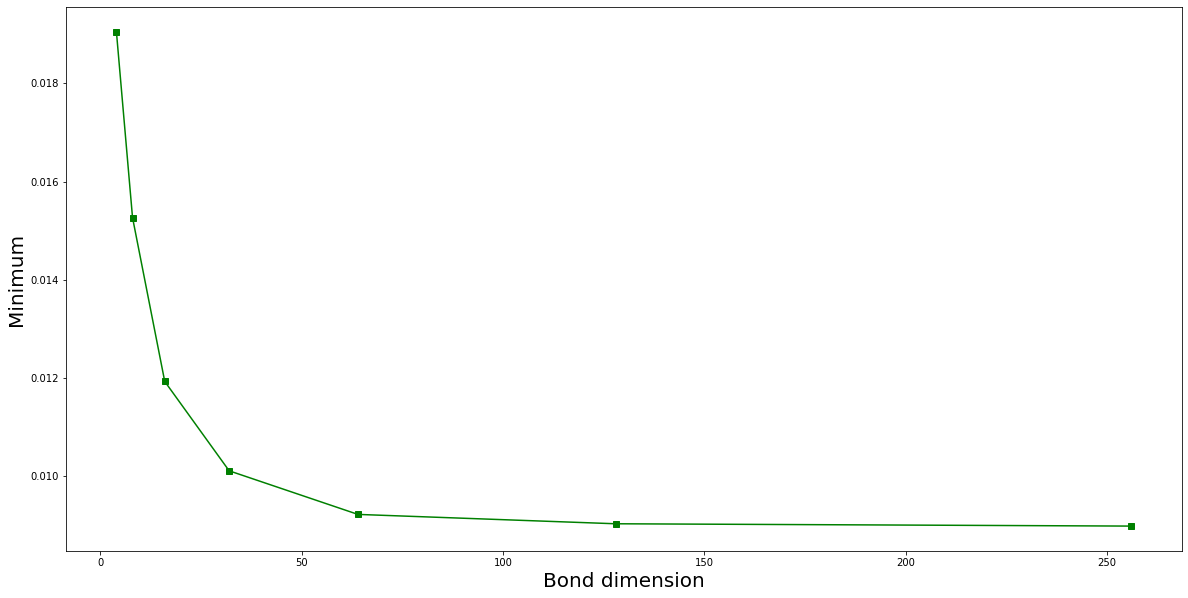

Mininimum
0.008982867458304566

CPU times: user 17min 34s, sys: 14min 11s, total: 31min 46s
Wall time: 8min 40s


In [406]:
tn.set_default_backend("jax")

##### -ZZ+hZ+gX model #############
#######################################

##### Set bond dimensions and simulation options
chi = 16
chid = 4
N = 10
#print('The length of the Ising spin chain:',N)
print('H = - ZZ + hZ + gX')

OPTS_numsweeps = 1 # number of DMRG sweeps
OPTS_dispon = 1 # level of output display
OPTS_updateon = True # level of output display
OPTS_maxit = 2 # iterations of Lanczos method
OPTS_krydim = 13 # dimension of Krylov subspace

acc = 50

#printentrhdensmatr()

#printentrlocdensmatr()

entrlocarray=[]

h = 0.1
%time CalculateEnergy()